In [1]:
suppressPackageStartupMessages(library(dplyr))
library(ggplot2)
library(pheatmap)
library(repr)
library(qvalue)
library(Seurat)
library(mclust)
library(RColorBrewer)

suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(InteractionSet))

source("/projects/ps-renlab2/y2xie//scripts/basics.R")
source("/projects/ps-renlab2/y2xie//scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie//scripts/DPT/BICAN_help.R")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Package 'mclust' version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand


Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [2]:
### Add brain region color
cols <- read.csv("../../ref/yel_Science2023_supp/brain_dissection_anno.xls", sep = "\t")
col1 <- cols %>% select(Brain.structure.name, Brain.structure.color) %>% distinct %>% select(Brain.structure.color) %>% unlist
names(col1) <- cols %>% select(Brain.structure.name, Brain.structure.color) %>% distinct %>% select(Brain.structure.name) %>% unlist

col2 <- cols %>% select(Brain.region, Brain.region.color) %>% distinct %>% select(Brain.region.color) %>% unlist
names(col2) <- cols %>% select(Brain.region, Brain.region.color) %>% distinct %>% select(Brain.region) %>% unlist

In [3]:
cols <- read.csv("../../ref/yel_Science2023_supp/subclass_celltype_match.csv")
tmp <- distinct(cols[,c("Cell.class", "Cell.class.color")])
ccol1 <- tmp$Cell.class.color
names(ccol1) <- gsub("GLUT", "Glut", tmp$Cell.class)

tmp <- read.csv("../04.clustering/subclass_corrected.color.csv", row.names = 1)
ccol2 <- tmp$color
names(ccol2) <- tmp$MiniAtlas

In [4]:
corder <- read.table("../04.clustering/order.subclass.250601", sep = "\t") %>% select(V1) %>% unlist %>% as.character
corder2 <- read.table("../04.clustering/order.cluster.250601", sep = "\t") %>% select(V1) %>% unlist %>% as.character

In [5]:
rmeta <- read.csv("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", sep = '\t')
table(rmeta$target, rmeta$subclass_corrected)

          
           ACBGM   AST  CBGA  ENDO   FBL IMMUNE L23IT  L2IT L34IT L35IT L45IT
  H3K27ac   3860 16120  3354   251   300     62 18441 12148 18121  7791 12276
  H3K27me3  1952 15984  4032   419   389     73 26892 20035 24363  9959 19244
          
            L4IT L56IT L56NP  L5ET  L5IT   L6B  L6CT L6IT-1 L6IT-2 LAMP5
  H3K27ac   2665 15846  2811   478  3903  5779  7299  11303   4705  5072
  H3K27me3  4467 20862  3371   434  5202  5973  8371  14054   5108  2221
          
           LAMP5-LHX6   LRL   MGC   MSN   OGC   OPC  PAX6 PV-CHC PVALB  SNCG
  H3K27ac        2745  6413  4367   830 72982 15714   969   1468 11816  1857
  H3K27me3        914  6227  4618   591 73879 16060   358   1487 14941   697
          
             SST SST-CHODL   URL   VIP
  H3K27ac  16060       376 39202 11713
  H3K27me3 17883       332 72448  8140

In [7]:
### read aligned subclass information
pair_df <- read.table("/projects//ps-renlab2/y2xie/projects/BICAN/analysis/06.integration/snm3c_snATAC_DPT_RNA_250601.pred_subclass_match.txt", header = T) # %>% setNames(c("MiniAtlas", "YELi", "snm3c"))

In [9]:
hg38t <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/refdata-cellranger-GRCh38.p13_v43/GRCh38/genes/tss_1500bp.bed")
head(hg38t, 3)

,V1,V2,V3,V4,V5,V6,V7
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
1,chr1,10869,12369,ENSG00000290825,.,+,DDX11L2
2,chr1,28554,30054,ENSG00000243485,.,+,MIR1302-2HG
3,chr1,35581,37081,ENSG00000237613,.,-,FAM138A


## Annotate H3K27ac+ cCREs using chromatin states

In [10]:
### read ccre-by-cell matrix with ccre information from Li et al., 2023
cmtx <- read.csv("../07.cCREs/MiniAtlas_H3K27ac_snATAC_whole.union.peaks_250722.subclass_corrected.cpm.csv", row.names = 1, check.names = F)

### read chromatin states annotation at ccres
clist <- list()
for (fname in pair_df$MiniAtlas){
    f <- paste0(fname, "_hba.whole.union.peaks.anno.bed")
    # ct2 <- pair_df[pair_df$MiniAtlas == fname,]$YELi
    if (file.exists(paste0("../10.chromhmm/output/DNAme_hyperCGN//annotation/", f))){
        tmp <- read.table(paste0("../10.chromhmm/output/DNAme_hyperCGN//annotation/", f))
        
        ### read subclass accessible ccre
        ccre <- read.table(paste0("cCREs/", fname, ".bed"))
        clist[[fname]] <- merge(tmp[,1:5], ccre[,c(4,8)], by = "V4") 
    }
}

length(clist) ### MSN are removed

[1] 31

In [36]:
df <- lapply(clist, function(x) data.frame(pf = length(which(x$V5 %in% c("E8", "E7", "E6"))),  ### active
                                           npf = length(which(x$V5 %in% c("E1", "E2", "E3", "E4", "E5", "E9"))))) ### repressive and open
df <- do.call(rbind, df)
df$celltype <- names(clist)

In [46]:
system("mkdir cCREs_w_H3K27ac_chmm")
for (fname in names(clist)){
    tmp <- clist[[fname]]
    tmp <- tmp %>% mutate(range = paste0(V1, ":", V2, "-", V3)) %>%
    mutate(V8 = ifelse(V5 %in% c("E8", "E7", "E6"), "w_ac", "wo_ac")) %>%
    select(V1, V2, V3, V4, range, V5, V8)
    write.table(tmp, paste0("cCREs_w_H3K27ac_chmm/", fname, "_H3K27ac_anno.bed"), 
                row.names = F, col.names = F, sep = "\t", quote = F)
}

In [9]:
### Bad cell types assignment: not included in the chromhmm learn model due to data sparsity
tmp <- read.table("../10.chromhmm/binary/valid.celltype")
tmp <- setdiff(corder, tmp$V1)

d2 <- table(rmeta[rmeta$target == "H3K27ac", ]$subclass_corrected) %>% as.data.frame
tmp1 <- d2 %>% filter(Freq < 500) %>% select(Var1) %>% unlist

d2 <- table(rmeta[rmeta$target == "H3K27me3", ]$subclass_corrected) %>% as.data.frame
tmp2 <- d2 %>% filter(Freq < 500) %>% select(Var1) %>% unlist

badcelltype <- Reduce(intersect, list(tmp, tmp1, tmp2))

## Validate classification with histone peaks

In [13]:
olist <- slist <- list()
for (f in list.files("../07.cCREs/cCREs_w_H3K27ac_chmm/", pattern = ".*_H3K27ac.anno.bed$")){
    fname <- gsub("_H3K27ac.anno.bed", "", f)
    ccre <- read.table(paste0("../07.cCREs/cCREs_w_H3K27ac_chmm/", f))
    peaks <- read.table(paste0("../05.peaks_calling/250601/parseK27ac/", fname, ".naivePeakList.narrowPeak.gz"))
    crange1 <- GenomicRanges::GRanges(ccre[ccre$V7 == "w_ac", 1], 
                                      IRanges::IRanges(as.integer(ccre[ccre$V7 == "w_ac", 2]), as.integer(ccre[ccre$V7 == "w_ac", 3])))
    crange2 <- GenomicRanges::GRanges(ccre[ccre$V7 == "wo_ac", 1], 
                                      IRanges::IRanges(as.integer(ccre[ccre$V7 == "wo_ac", 2]), as.integer(ccre[ccre$V7 == "wo_ac", 3])))
    prange <- GenomicRanges::GRanges(peaks[, 1], IRanges::IRanges(as.integer(peaks[, 2]), as.integer(peaks[, 3])))
    idx <- S4Vectors::queryHits(GenomicRanges::findOverlaps(crange1, prange)) %>% unique
    idy <- S4Vectors::queryHits(GenomicRanges::findOverlaps(crange2, prange)) %>% unique
    
    wsignal <- cmtx[ccre[ccre$V7 == "w_ac", 5], fname, drop = F] %>% setNames("signal") %>% mutate(group = "w_ac", subclass = fname)
    wosignal <- cmtx[ccre[ccre$V7 == "wo_ac", 5], fname, drop = F] %>% setNames("signal") %>% mutate(group = "wo_ac", subclass = fname)

    slist[[fname]] <- rbind(wsignal, wosignal)
    olist[[fname]] <- data.frame(nrow(ccre[ccre$V7 == "w_ac",]), nrow(ccre[ccre$V7 == "wo_ac",]), 
                                 length(idx), length(idy))
}

Using subclass as id variables



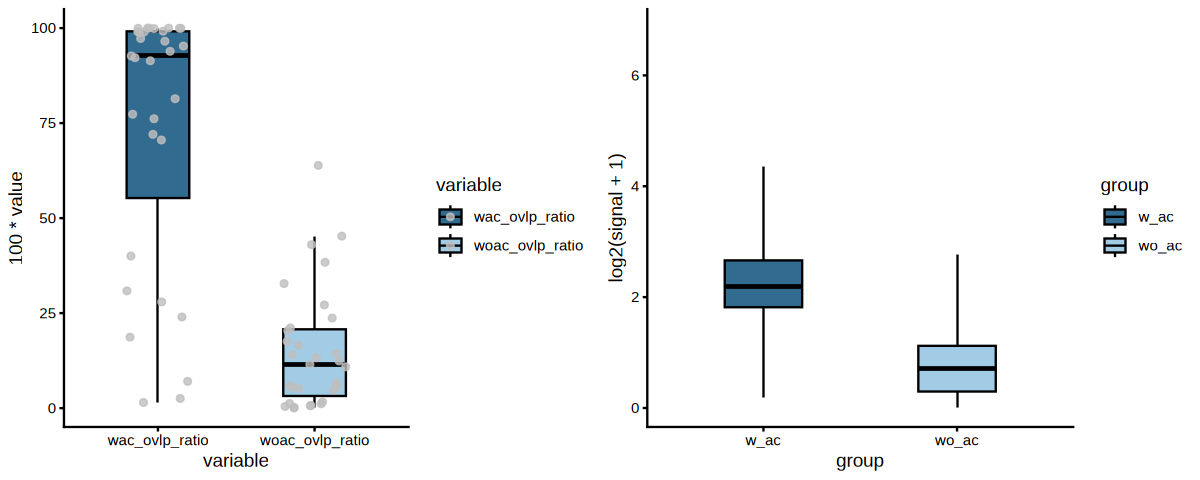

In [127]:
### Do they overlap with peaks more? Number of peaks overlap?
t1 <- do.call(rbind, olist) %>% setNames(c("ccre_wac", "ccre_woac", "wac_ovlp_peaks", "woac_ovlp_peaks")) %>%
mutate(wac_ovlp_ratio = wac_ovlp_peaks/ccre_wac, woac_ovlp_ratio = woac_ovlp_peaks/ccre_woac) %>%
tibble::rownames_to_column("subclass") %>% 
select(wac_ovlp_ratio, woac_ovlp_ratio, subclass) %>%
reshape2::melt() %>%
ggplot(aes(x = variable, y = 100*value, fill = variable)) + 
geom_boxplot(width=0.4, color="black", alpha=1, coef = 2, outlier.shape = NA) + 
geom_jitter(alpha=0.8, color = "grey", width = 0.2) + 
theme_classic() + 
scale_fill_manual(values = c("#316b8f", "#a2cce6")) 

### H3K27ac signal?
t2 <- do.call(rbind, slist) %>% 
ggplot(aes(x = group, y = log2(signal + 1), fill = group)) + 
# stat_boxplot(geom = "errorbar", width = 0.3, coef = 2) +
geom_boxplot(width=0.4, color="black", alpha=1, coef = 2, outlier.shape = NA) + 
theme_classic() + 
scale_fill_manual(values = c("#316b8f", "#a2cce6")) 

options(repr.plot.width = 10, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2)

fig1

Using subclass as id variables



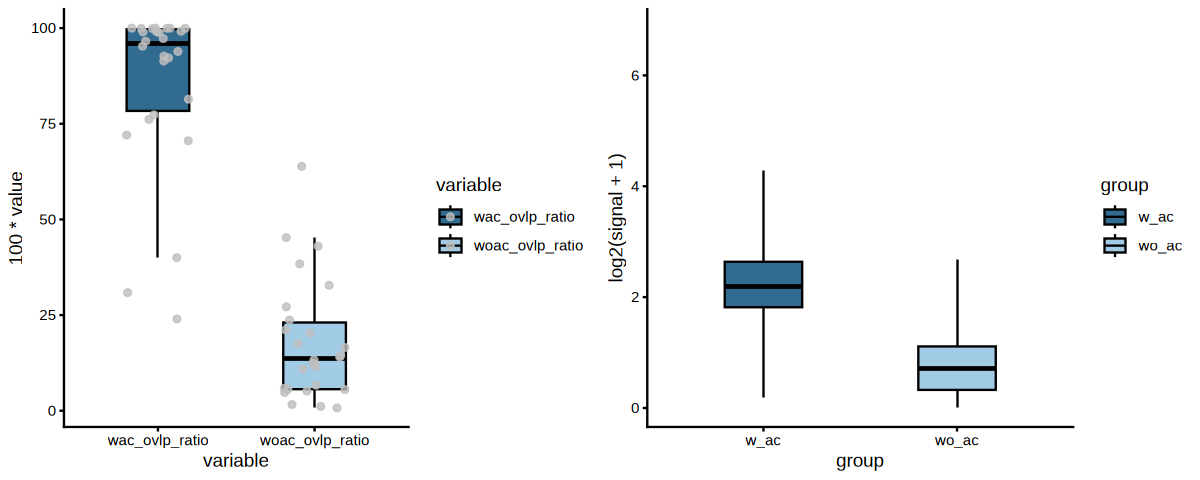

In [129]:
### Filter bad celltypes 

t1 <- do.call(rbind, olist) %>% setNames(c("ccre_wac", "ccre_woac", "wac_ovlp_peaks", "woac_ovlp_peaks")) %>%
mutate(wac_ovlp_ratio = wac_ovlp_peaks/ccre_wac, woac_ovlp_ratio = woac_ovlp_peaks/ccre_woac) %>%
tibble::rownames_to_column("subclass") %>% filter(!(subclass %in% badcelltype)) %>%
select(wac_ovlp_ratio, woac_ovlp_ratio, subclass) %>%
reshape2::melt() %>%
ggplot(aes(x = variable, y = 100*value, fill = variable)) + 
geom_boxplot(width=0.4, color="black", alpha=1, coef = 2, outlier.shape = NA) + 
geom_jitter(alpha=0.8, color = "grey", width = 0.2) + 
theme_classic() + 
scale_fill_manual(values = c("#316b8f", "#a2cce6")) 

### H3K27ac signal?
t2 <- do.call(rbind, slist) %>% filter(!(subclass %in% badcelltype)) %>%
ggplot(aes(x = group, y = log2(signal + 1), fill = group)) + 
# stat_boxplot(geom = "errorbar", width = 0.3, coef = 2) +
geom_boxplot(width=0.4, color="black", alpha=1, coef = 2, outlier.shape = NA) + 
theme_classic() + 
scale_fill_manual(values = c("#316b8f", "#a2cce6")) 

options(repr.plot.width = 10, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2)

fig1

In [130]:
ggsave(fig1, filename = "../Figure/FIG2_ATAC_stratify_by_chromatin_states_H3K27ac_peak_compare.filter.pdf", 
       dpi = 300, height = 4, width = 10)

In [14]:
qct <- do.call(rbind, slist) %>% select(subclass) %>% unique %>% unlist %>% as.character
qct <- setdiff(qct, badcelltype)
qct %>% length
### Analyze 26 cell subclasses in total!!

[1] 26

In [15]:
write.table(qct, "../07.cCREs/cCREs_w_H3K27ac_chmm/subclass_to_analyze.list", row.names = F, col.names = F, sep = "\t", quote = F)

In [75]:
### Whats the distance to the closest peaks summit
clist <- list()
for (f in list.files("../07.cCREs/cCREs_w_H3K27ac_chmm/closest/", pattern = "_closet_summit.bedpe")){
    fname <- gsub("_closet_summit.bedpe", "", f)
    clist[[fname]] <- read.table(paste0("../07.cCREs/cCREs_w_H3K27ac_chmm/closest/", f)) %>%
    mutate(distance = V11, subclass = fname) %>%
    select(distance, subclass, V7) %>% setNames(c("distance", "subclass", "class"))
}

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 1036 rows containing non-finite outside the scale range (`stat_boxplot()`).”


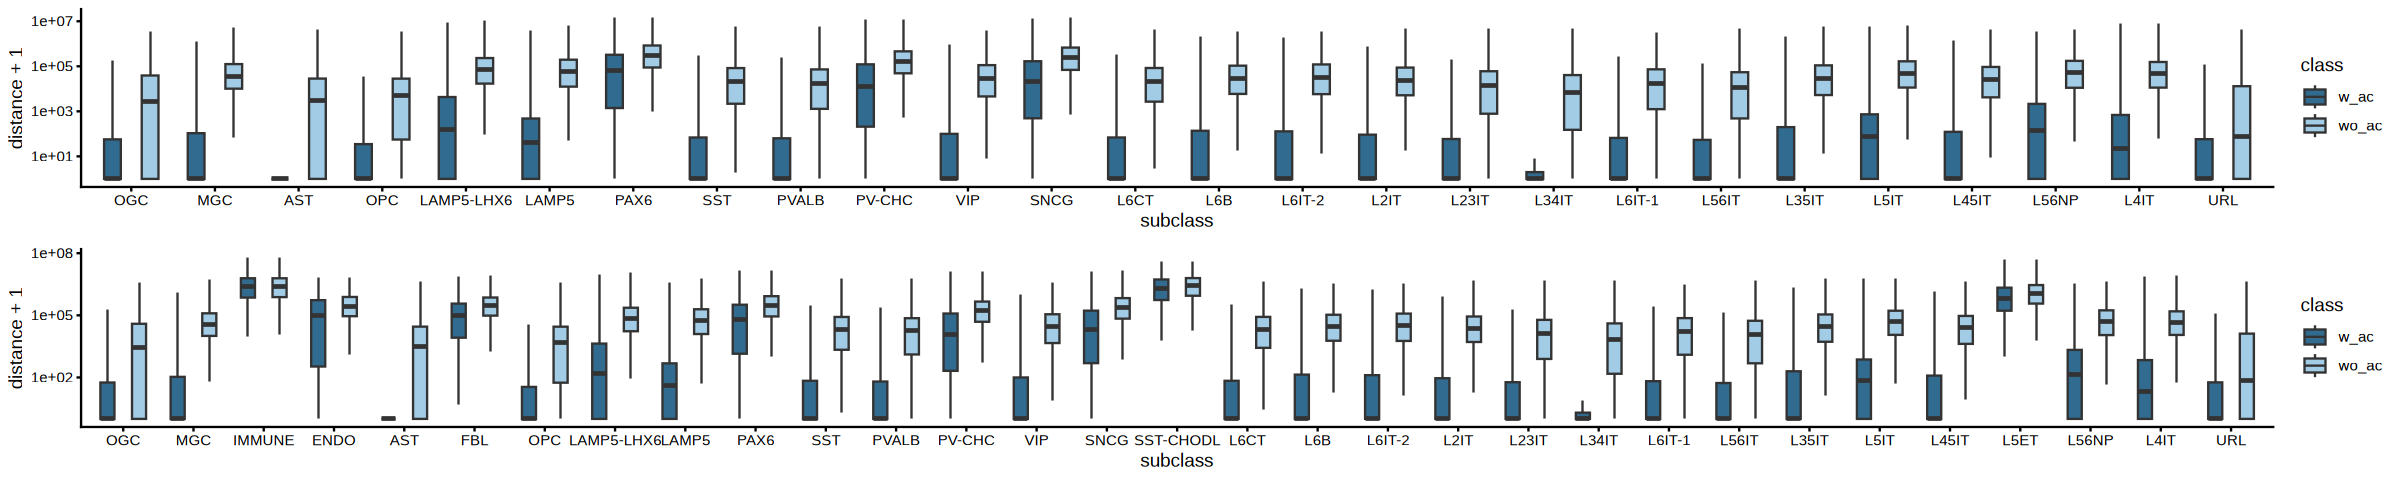

In [109]:
t1 <- do.call(rbind, clist) %>% 
filter(subclass %in% qct) %>%
mutate(subclass = factor(subclass, levels = corder)) %>%
ggplot(aes(x = subclass, y = distance + 1, fill = class)) + 
geom_boxplot(width = 0.4, position = position_dodge(0.9), coef = 2, outlier.shape = NA) +
theme_classic() + scale_y_log10() + 
scale_fill_manual(values = c("#316b8f", "#a2cce6")) 

t2 <- do.call(rbind, clist) %>% 
mutate(subclass = factor(subclass, levels = corder)) %>%
ggplot(aes(x = subclass, y = distance + 1, fill = class)) + 
geom_boxplot(width = 0.4, position = position_dodge(0.9), coef = 2, outlier.shape = NA) +
theme_classic() + 
scale_y_log10() + 
scale_fill_manual(values = c("#316b8f", "#a2cce6")) 

options(repr.plot.width = 20, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2, nrow = 2)
fig1

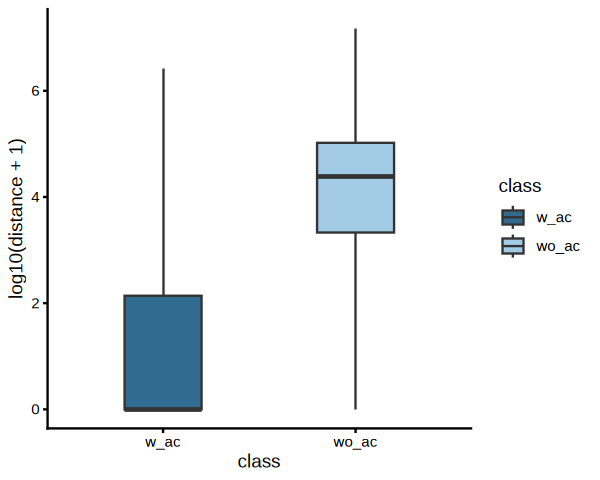

In [115]:
t1 <- do.call(rbind, clist) %>% filter(subclass %in% qct) %>%
mutate(subclass = factor(subclass, levels = corder)) %>%
ggplot(aes(x = class, y = log10(distance + 1))) + 
geom_boxplot(aes(fill = class), width = 0.4, position = position_dodge(0.9), coef = 2, outlier.shape = NA) +
theme_classic() + 
scale_fill_manual(values = c("#316b8f", "#a2cce6")) 

options(repr.plot.width = 5, repr.plot.height = 4)
t1

ggsave(t1, filename = "../Figure/FIG2_ATAC_stratify_by_chromatin_states_distance_to_closest_H3K27ac_summit.pdf", 
       dpi = 300, height = 4, width = 4)

## ATAC / H3K27ac siganl visualziation

In [131]:
### manually add one column
atac <- read.csv("../../ref/hba_ATAC/snATAC_subclass_cCRE.cpm.csv", row.names = 1)
atac2 <- read.csv("../../ref/hba_ATAC/snATAC_subclass2_cCRE.cpm.csv", row.names = 1)

"AST" %in% colnames(atac)
"AST" %in% colnames(atac2)
atac$AST <- atac2[rownames(atac),]$AST

[1] FALSE

[1] TRUE

In [175]:
ccre <- list()
for (fname in qct){
    f <- paste0(fname, "_H3K27ac_anno.bed")
    ccre[[fname]] <- read.table(paste0("../07.cCREs/cCREs_w_H3K27ac_chmm/", f))
}
ccre <- do.call(rbind, ccre) %>% select(V1, V2, V3, V4, V5) %>% distinct
nrow(ccre)

[1] 467900

In [14]:
### read order for plotting the same as Li et al., 2023
nmf <- read.csv("../../ref//yel_Science2023_supp/cCREs_module_element.txt", sep = "\t", header = F) %>% filter(V1 %in% ccre$V4)
nmfo <- read.csv("../../ref//yel_Science2023_supp/cCREs_module_subclass_order.xls", 
                 sep = "\t", header = T, row.names = 1, check.names = FALSE)
colnames(nmfo) <- gsub("/", "", colnames(nmfo))
colnames(nmfo) <- gsub("IT-", "IT", colnames(nmfo))
colnames(nmfo) <- gsub("-", "_", colnames(nmfo))
colnames(nmfo) <- gsub("LAMP5_2", "LAMP5_LHX6", colnames(nmfo))
colnames(nmfo) <- gsub("LAMP5_1", "LAMP5", colnames(nmfo))

# nmfo$AST <- apply(nmfo[,c('ASCT','ASCNT')], MARGIN = 1, mean)

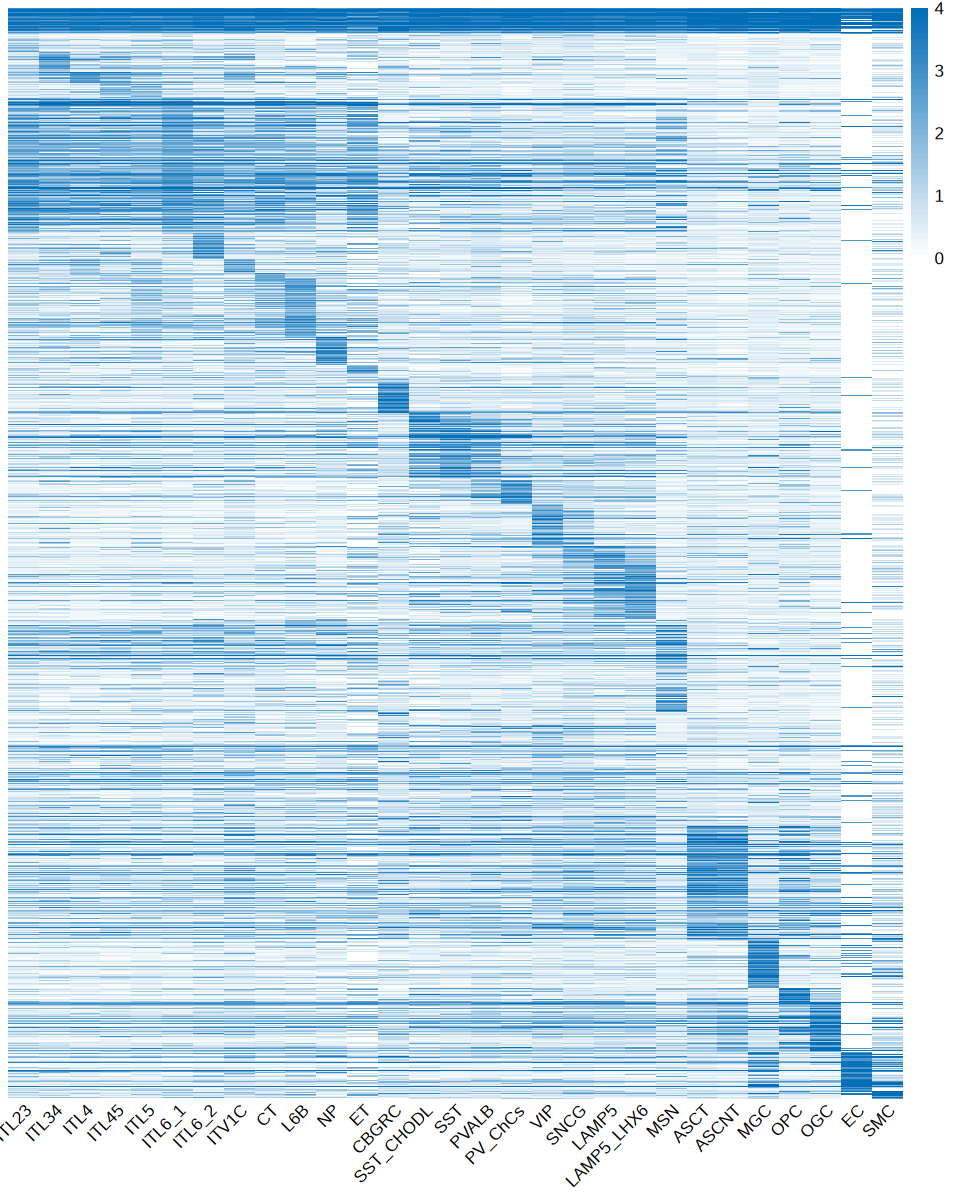

In [179]:
### Plot ATAC
rmat <- atac
match_name <- c(intersect(colnames(nmfo), unique(pair_df[pair_df$MiniAtlas %in% qct,]$YELi)), "ASCNT")
match_name <- match_name[match(colnames(nmfo), match_name)][!is.na(match_name[match(colnames(nmfo), match_name)])]
porder <- nmf %>% mutate(V2 = factor(V2, levels = rownames(nmfo))) %>% arrange(V2)

smat <- rmat[ccre[match(porder$V1, ccre$V4), ]$V5, match_name]
smat <- log2(smat + 1)

options(repr.plot.width = 8, repr.plot.height = 10)
smat %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 45, 
         border_color = NA, show_rownames = F, breaks = seq(0, 4, 0.08), 
         color = colorRampPalette(c("white", "#036EB8"))(50))

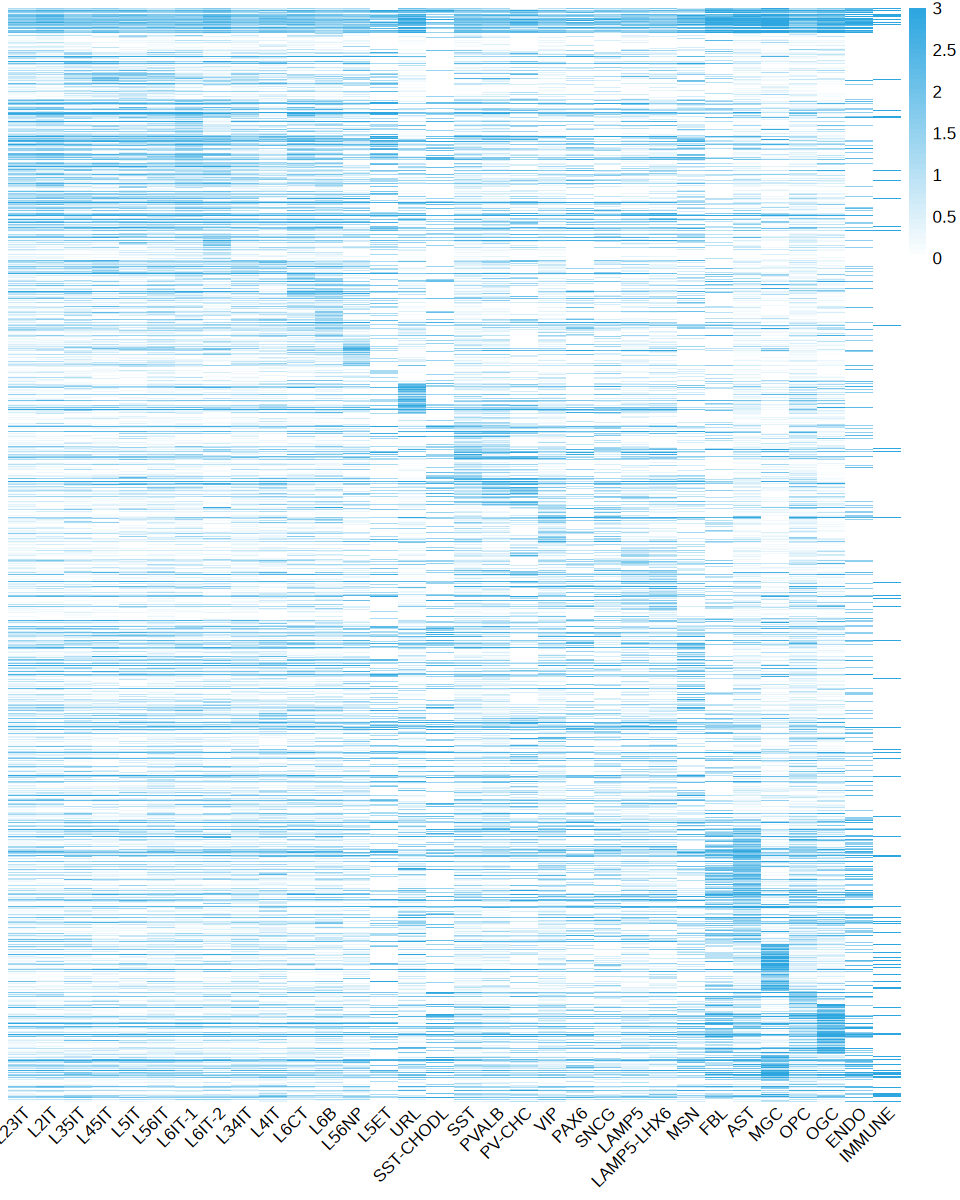

In [187]:
### Plot H3K27ac, as order in Li et al Science 2023
match_name2 <- gsub("ASCNT", "AST", match_name)
match_name3 <- pair_df %>% mutate(YELi = factor(YELi, levels = match_name2)) %>% 
filter(!is.na(YELi)) %>% arrange(YELi) %>% 
dplyr::select(MiniAtlas) %>% unlist

rmat <- cmtx
smat1 <- rmat[gorder, match_name3]
smat1 <- log2(smat1 + 1)
# smat1[smat1>3] <- 3

options(repr.plot.width = 8, repr.plot.height = 10)
smat1 %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 45, 
         border_color = NA, show_rownames = F, breaks = seq(0, 3, 0.06), 
         color = colorRampPalette(c("white", "#2EA7E0"))(50))

## Summarize H3K27ac+ and H3K27ac- cCREs

In [137]:
lcts <- list()
for (fname in qct){
    fmatch <- pair_df[pair_df$MiniAtlas == fname,]$YELi
    if (!is.na(fmatch)){
        lcts[[fname]] <- read.csv(paste0("../07.cCREs/cCREs_w_H3K27ac_chmm/", fname, "_H3K27ac_anno.bed"), sep = "\t", header = F) %>% 
        mutate(group = ifelse(V7 == "w_ac", "sig", "nonsig"), subclass = fname)
    }
}

### non-H3K27ac: 
nonsigcre <- do.call(rbind, lcts) %>% filter(group == "nonsig") %>% dplyr::select(V5) %>% unlist %>% unique
sigcre <- do.call(rbind, lcts) %>% filter(group == "sig") %>% dplyr::select(V5) %>% unlist %>% unique
stag <- intersect(nonsigcre, sigcre)

nonsigcre <- setdiff(nonsigcre, stag)
sigcre <- setdiff(sigcre, nonsigcre) ### at least one subclass with K27ac

length(stag)
length(sigcre)
length(nonsigcre)

[1] 159587

[1] 222165

[1] 245735

In [150]:
length(sigcre)/(length(sigcre) + length(nonsigcre))

[1] 0.474813

In [163]:
match_name4 <- intersect(match_name3, qct)
match_name5 <- setdiff(colnames(smat), c("ET", "SST_CHODL", "MSN", 'EC', 'SMC'))

In [149]:
### Plot H3K27ac
smat1 <- do.call(rbind, lcts) %>% filter(group == "sig") %>%
filter(subclass %in% match_name4) %>%
filter(V5 %in% sigcre) %>%
mutate(subclass = factor(subclass, levels = match_name4)) %>%
arrange(subclass) %>%
group_by(subclass) %>%
mutate(V5 = factor(V5, levels = gorder)) %>%
arrange(V5) %>%
mutate(V6 = V5)

smat2 <- do.call(rbind, lcts) %>% filter(group == "nonsig") %>%
filter(subclass %in% match_name4) %>%
filter(V5 %in% nonsigcre) %>%
mutate(subclass = factor(subclass, levels = match_name4)) %>%
arrange(subclass) %>%
group_by(subclass) %>%
mutate(V5 = factor(V5, levels = gorder)) %>%
arrange(V5) %>%
mutate(V6 = V5)

### double check

unique(smat1$V6) %>% length
unique(smat2$V6) %>% length
unique(c(smat1$V6, smat2$V6)) %>% length

[1] 222165

[1] 245735

[1] 467900

In [2]:
## set colors
library(scales)
library(TSP)
hex_colors <- c("#634aad","#b5b235","#577ceb","#60b04c","#9778e2","#9fc05c","#462b7a","#64c77a","#cf5eb6","#4ac08f","#d84889",
                "#33d4d1","#da504c","#5885de","#d38a32","#5759a2","#b69c41","#b274d4","#5d7b25","#89317c","#3c7a3b","#cc8ad2","#bea65e",
                "#6f97dd","#be542b","#782252","#da8b57","#a83769","#875a1d","#dd79a5","#7f2618","#d0496b","#d2745b","#89253d","#df646b","#a4303d","#ce6c7a")

rgb <- col2rgb(hex_colors)
tsp <- as.TSP(dist(t(rgb)))
sol <- solve_TSP(tsp, control = list(repetitions = 1e3))
sorted_colors <- hex_colors[sol]

Warning message:
“executing %dopar% sequentially: no parallel backend registered”


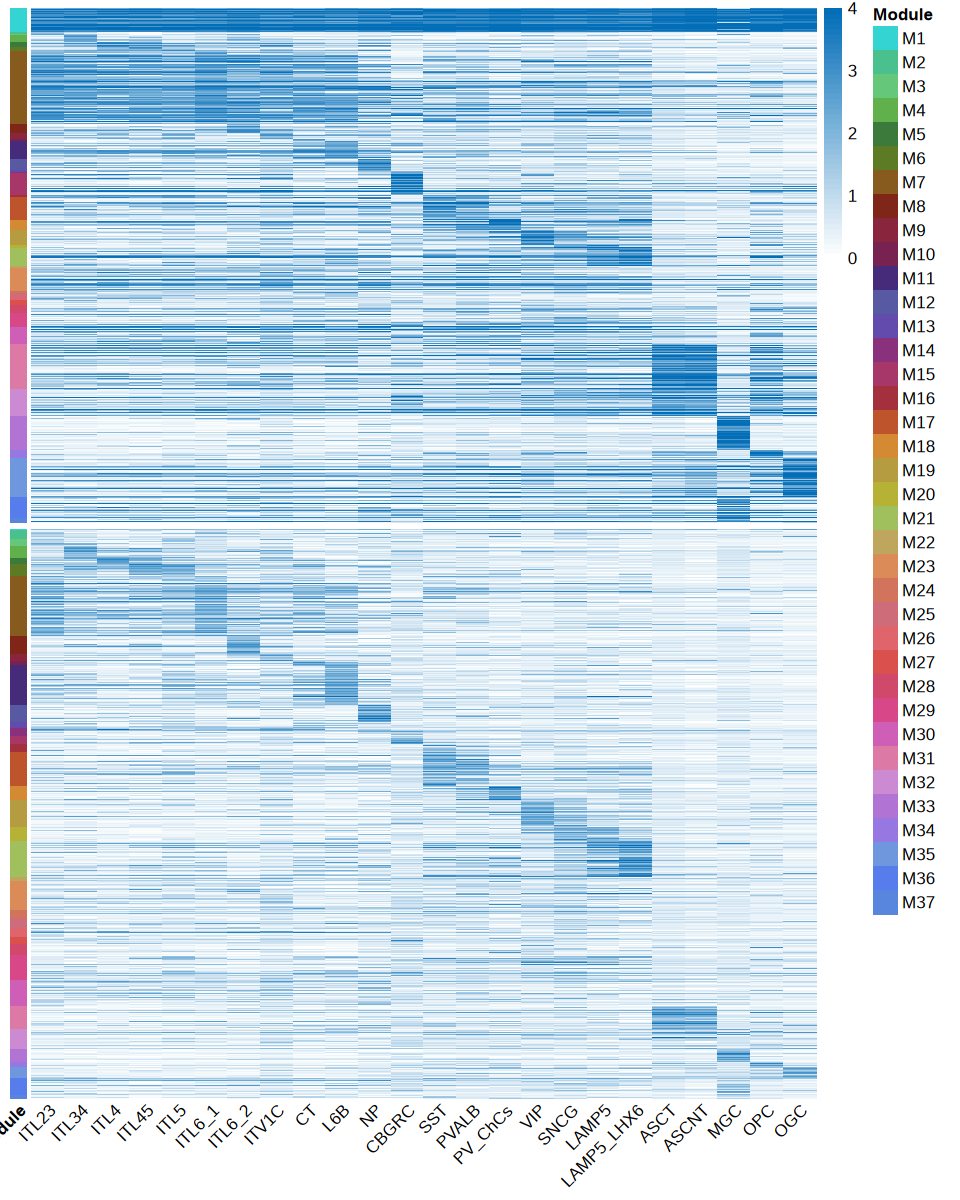

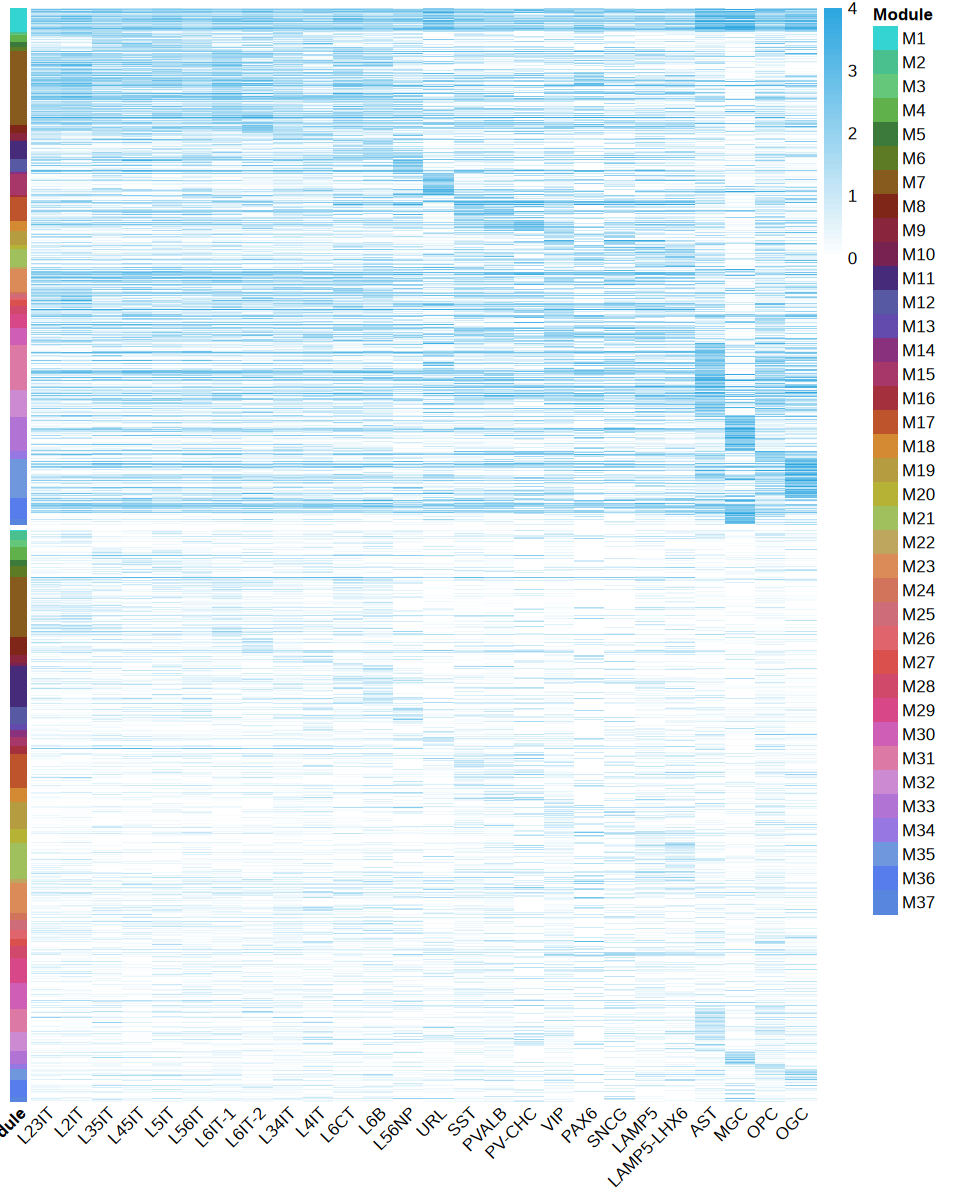

In [166]:
options(repr.plot.width = 8, repr.plot.height = 10)

### ATAC
### with NMF classes labeled
ranno <- rbind(smat1[,c("V4", "V6")], smat2[,c("V4", "V6")]) %>% distinct
ranno <- merge(ranno, nmf, by.x = "V4", by.y = "V1") %>%
dplyr::select(c(V6, V2)) %>%
tibble::column_to_rownames("V6") %>% setNames("Module")

rannocolor <- sorted_colors
names(rannocolor) <- stringr::str_sort(unique(ranno$Module), numeric = T)
rannocolor <- list(Module = rannocolor)

gorder2 <- as.character(c(unique(smat1$V6), unique(smat2$V6)))

### smat already scaled
t1 <- smat[gorder2, match_name5] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 45, 
         annotation_row = ranno, annotation_colors = rannocolor,
         gaps_row = c(length(unique(smat1$V6))),
         border_color = NA, show_rownames = F, breaks = seq(0, 4, 0.08), 
         color = colorRampPalette(c("white", "#036EB8"))(50))

### H3K27ac
qmtx <- log2(cmtx[gorder2, match_name4]+1)
t2 <- qmtx %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 45, 
         annotation_row = ranno, annotation_colors = rannocolor,
         gaps_row = c(length(unique(smat1$V6))),
         border_color = NA, show_rownames = F, breaks = seq(0, 4, 0.08), 
         color = colorRampPalette(c("white", "#2EA7E0"))(50)) 

## Intersect with snm3c loops from Tian 2023

In [22]:
### read in proximal / distal separation based on -1kb and +500bp
pccre <- read.table("../07.cCREs/cCREs/cCREs.collapse.proximal.bed") %>% mutate(range = paste0(V1, ":", V2, "-", V3))

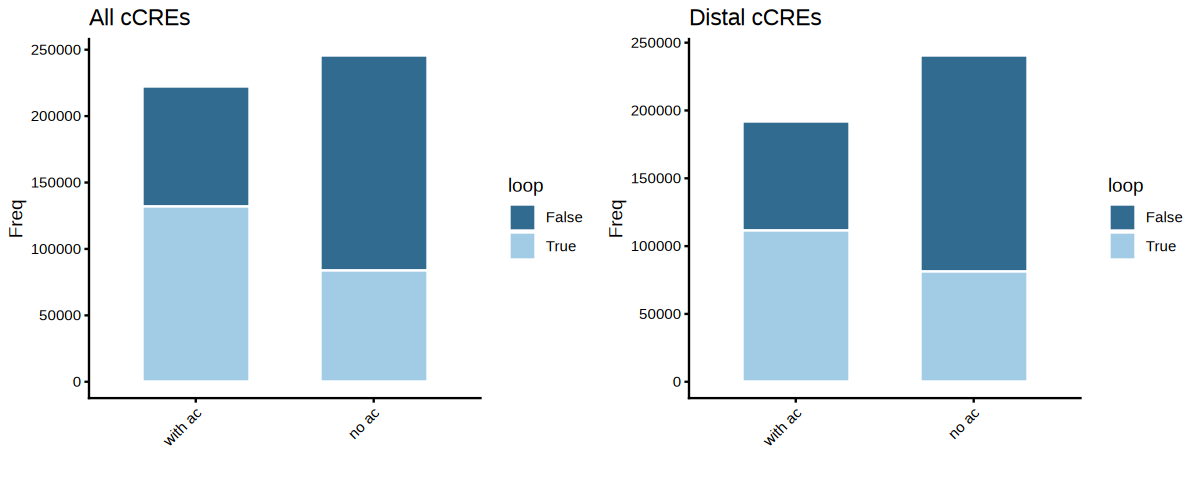

In [204]:
suppressPackageStartupMessages(library(GenomicRanges))
loop <- read.table("../../ref/hba_snm3c/loop/group.loop.bedpe")
l1 <- loop[,1:3] %>% distinct
l2 <- loop[,4:6] %>% distinct %>% setNames(colnames(l1))
loop_anchors <- rbind(l1, l2)
looprange <- GRanges(loop_anchors[,1], ranges = IRanges(as.numeric(loop_anchors[,2]), as.numeric(loop_anchors[,3])))

nonsig <- stringr::str_split_fixed(nonsigcre, pattern = "[:-]", n = 3) %>% as.data.frame
sig <- stringr::str_split_fixed(sigcre, pattern = "[:-]", n = 3) %>% as.data.frame
wacrange <- GRanges(sig[, 1], ranges = IRanges(as.numeric(sig[, 2]), as.numeric(sig[, 3])))
nacrange <- GRanges(nonsig[, 1], ranges = IRanges(as.numeric(nonsig[, 2]), as.numeric(nonsig[, 3])))

f1 <- sig %>% mutate(loop = "False", group = "with ac")
f2 <- nonsig %>% mutate(loop = "False", group = "no ac")
f1[unique(queryHits(findOverlaps(wacrange, looprange))),]$loop <- "True"
f2[unique(queryHits(findOverlaps(nacrange, looprange))),]$loop <- "True"

t1 <- rbind(f1, f2)[,c("loop","group")] %>% table %>% as.data.frame %>%
mutate(group = factor(group, levels = c("with ac", "no ac"))) %>%
ggplot(aes(x = group, y = Freq, fill = loop)) + 
geom_col(width = 0.6, color = "white") + 
theme_classic() + xlab("") +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + ggtitle("All cCREs") + 
scale_fill_manual(values = c("#316b8f", "#a2cce6")) 

### exclude promoter proximal peaks
t2 <- rbind(f1, f2) %>% filter(!(paste0(V1, ":", V2, "-", V3) %in% pccre$range)) %>%
select(loop, group) %>% table %>% as.data.frame %>%
mutate(group = factor(group, levels = c("with ac", "no ac"))) %>%
ggplot(aes(x = group, y = Freq, fill = loop)) + 
geom_col(width = 0.6, color = "white") + 
theme_classic() + xlab("") +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + ggtitle("Distal cCREs") + 
scale_fill_manual(values = c("#316b8f", "#a2cce6")) 

options(repr.plot.width = 10, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2)
fig1

Warning message in geom_col(width = 0.6, color = "white", size = 0.5, position = "fill"):
“Ignoring unknown parameters: `size`”
Warning message in geom_col(width = 0.6, color = "white", size = 0.5, position = "fill"):
“Ignoring unknown parameters: `size`”


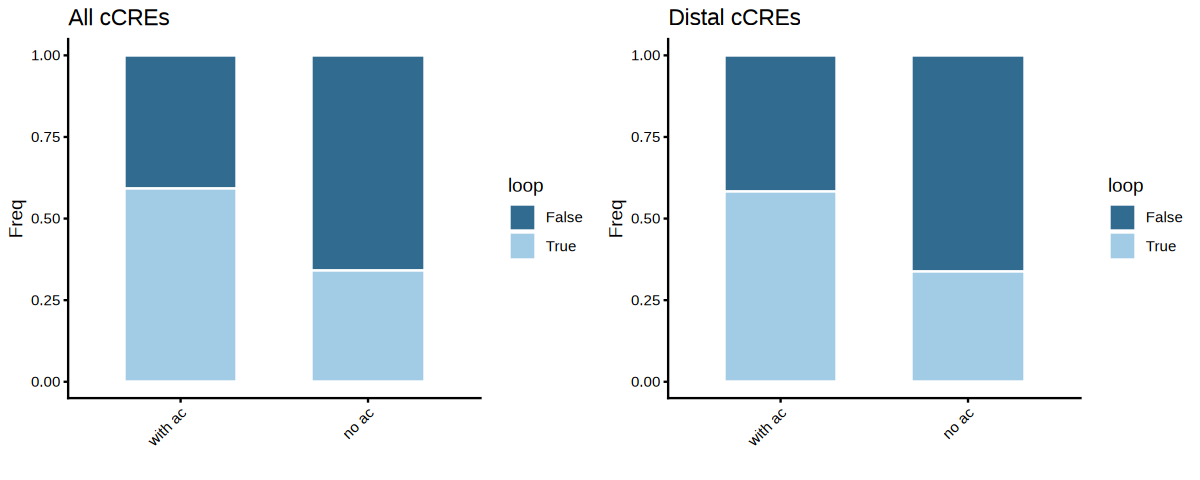

In [206]:
t1 <- rbind(f1, f2)[,c("loop","group")] %>% table %>% as.data.frame %>%
mutate(group = factor(group, levels = c("with ac", "no ac"))) %>%
ggplot(aes(x = group, y = Freq, fill = loop)) + 
geom_col(width = 0.6, color = "white", size = 0.5, position = "fill") + 
theme_classic() + xlab("") +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + ggtitle("All cCREs") + 
scale_fill_manual(values = c("#316b8f", "#a2cce6")) 

### exclude promoter proximal peaks
t2 <- rbind(f1, f2) %>% filter(!(paste0(V1, ":", V2, "-", V3) %in% pccre$range)) %>%
select(loop, group) %>% table %>% as.data.frame %>%
mutate(group = factor(group, levels = c("with ac", "no ac"))) %>%
ggplot(aes(x = group, y = Freq, fill = loop)) + 
geom_col(width = 0.6, color = "white", size = 0.5, position = "fill") + 
theme_classic() + xlab("") +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + ggtitle("Distal cCREs") + 
scale_fill_manual(values = c("#316b8f", "#a2cce6")) 

options(repr.plot.width = 10, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2)
fig1

In [2]:
write.table(nonsig, "../07.cCREs/cCREs_w_H3K27ac_chmm/wo_ac.ccre.all", sep = "\t", quote = F, row.names = F, col.names = F)
write.table(sig, "../07.cCREs/cCREs_w_H3K27ac_chmm/w_ac.ccre.all", sep = "\t", quote = F, row.names = F, col.names = F)

## Check genomic features

In [52]:
anno <- read.csv("cCREs/hba.whole.union.peaks.bed.anno", sep = "\t", header = T) %>% 
mutate(range = paste0(Chr, ":", Start-1, "-", End))

Warning message in geom_bar(width = 1, stat = "identity", color = "white", size = 0.5):
“Ignoring unknown parameters: `size`”
Warning message in geom_bar(width = 1, stat = "identity", color = "white", size = 0.5):
“Ignoring unknown parameters: `size`”


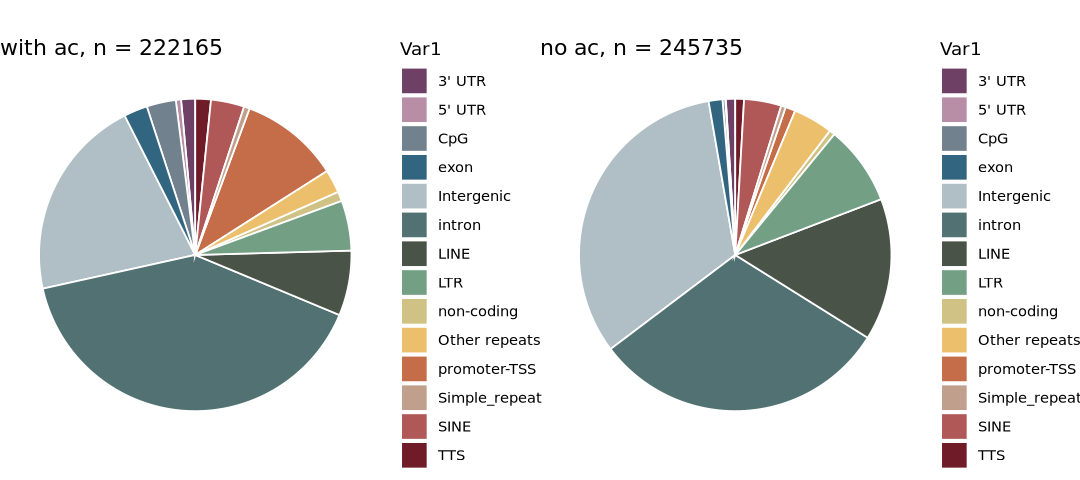

In [55]:
t1 <- sum_detailed_anno(anno[anno$range %in% sig$range,]) %>%
mutate(Var1 = factor(Var1, levels = sort(Var1))) %>%
ggplot(aes(x = "", y = Freq, fill = Var1)) +
geom_bar(width = 1, stat = "identity", color = "white", size = 0.5) +
coord_polar(theta = "y") + 
theme_void() + ggtitle(paste0("with ac, n = ", nrow(sig))) + 
scale_fill_manual(values = colfunc(14))

t2 <- sum_detailed_anno(anno[anno$range %in% nonsig$range,]) %>%
mutate(Var1 = factor(Var1, levels = sort(Var1))) %>%
ggplot(aes(x = "", y = Freq, fill = Var1)) +
geom_bar(width = 1, stat = "identity", color = "white", size = 0.5) +
coord_polar(theta = "y") + 
theme_void() + ggtitle(paste0("no ac, n = ", nrow(nonsig))) + 
scale_fill_manual(values = colfunc(14))

options(repr.plot.width = 9, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2)
fig1

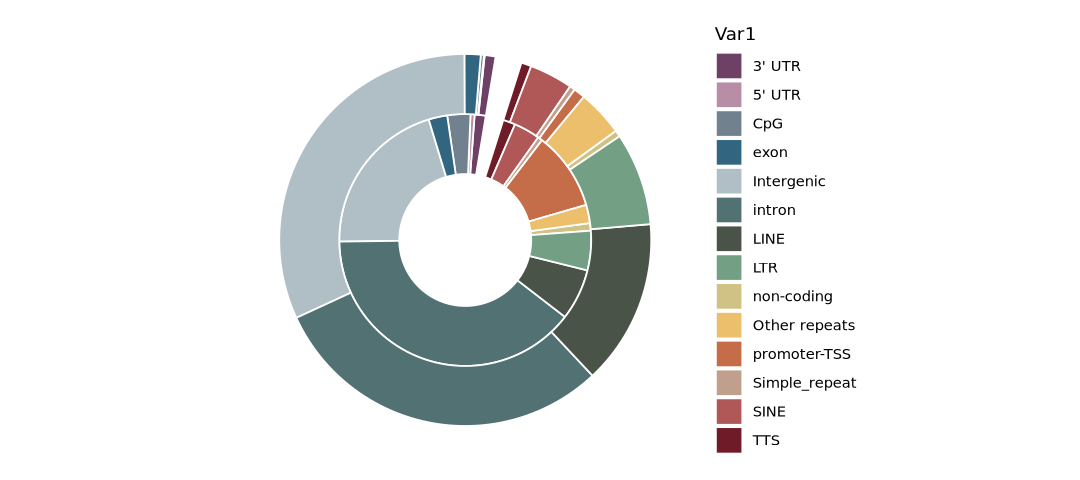

In [64]:
d1 <- t1$data %>% mutate(class = "wac") 
d2 <- t2$data %>% mutate(class = "woac") 
fig1 <- rbind(d1, d2) %>%
mutate(Var1 = factor(Var1, levels = sort(unique(Var1)))) %>%
ggplot(aes(x = class, y = Freq, fill = Var1)) +
geom_col(position = "fill", color = "white", width = 1) +
coord_radial(theta = "y", start = 0, end = 2.15 * pi, inner.radius = 0) + 
scale_x_discrete(limits = c(" ", "wac", "woac")) + 
# geom_bar(width = 1, stat = "identity", color = "white", size = 0.5) +
# coord_polar(theta = "y", start=0) + 
theme_void() + 
scale_fill_manual(values = colfunc(14))

fig1

In [ ]:
### Prepare for comparsion of elemetns!
sfbed <- read.table("tmp_shuffle.chromhmm.bed")
sfrange <- GRanges(sfbed[,1], ranges = IRanges(as.numeric(sfbed[,2]), as.numeric(sfbed[,3])))

## Overlap with CA diversity

In [29]:
cacons <- read.csv("./ref/yel_Science2023_supp/cCREs_category.txt", sep = "\t")
qct <- read.table("cCREs_w_H3K27ac_chmm/subclass_to_analyze.list") %>% select(V1) %>% unlist %>% as.character
pccre <- read.table("./analysis/07.cCREs/cCREs/cCREs.collapse.proximal.bed") %>% mutate(range = paste0(V1, ":", V2, "-", V3))

In [30]:
lca <- list()
for (fname in qct){
    fmatch <- pair_df[pair_df$MiniAtlas == fname,]$YELi
    if (!is.na(fmatch) & (fmatch %in% unique(cacons$subclass))){
        if (fmatch == "ITL6_1"){
            fmatch <- "ITL6"
        }
        tmp <- read.csv(paste0("../07.cCREs/cCREs_w_H3K27ac_chmm/", fname, "_H3K27ac_anno.bed"), sep = "\t", header = F) %>% 
        mutate(group = V7, subclass = fname)

        lca[[fname]] <- merge(tmp, cacons[cacons$subclass == fmatch, ], by.x = "V4", by.y = "cCRE") %>%
        filter(!(paste0(V1, ":", V2, "-", V3) %in% pccre$range)) %>%
        mutate(category = ifelse(is.na(category), "Unknown", category)) %>%
        dplyr::select(c(group, subclass.x, category)) %>% table %>% as.data.frame
    }
}
lca <- do.call(rbind, lca)

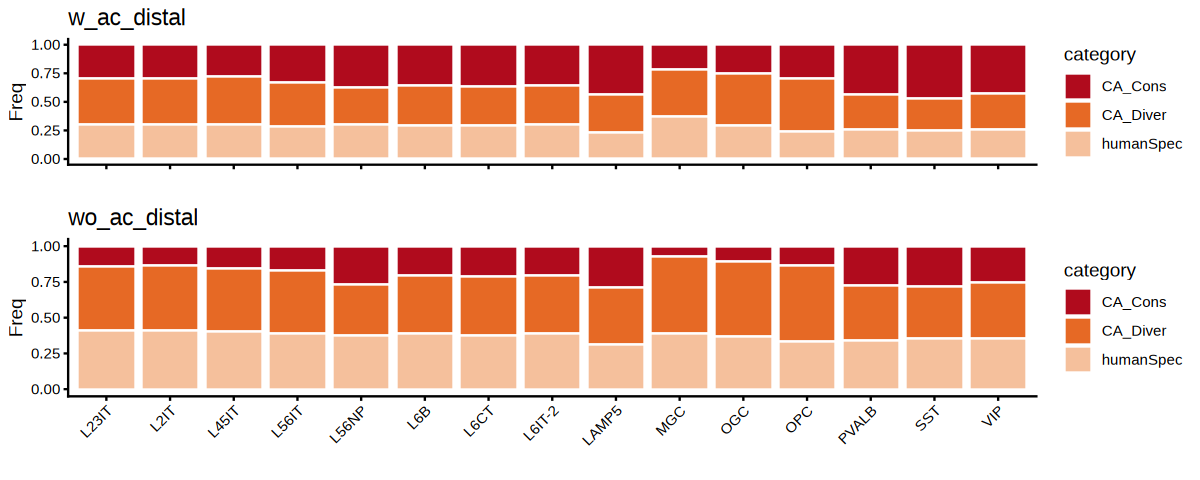

In [25]:
plist <- list()
for (f in unique(lca$group)){
    plist[[f]] <- lca %>% filter(group == f) %>%
    ggplot(aes(x = subclass.x, y = Freq, fill = category)) + 
    geom_col(position = "fill", color = "white") + xlab("") + 
    theme_classic() + ggtitle(paste0(f, "_distal")) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    scale_fill_manual(values = c('#b00b1d', '#e66925', '#f5c09c', '#66646a'))

}

fig1 <- cowplot::plot_grid(plist[[1]] + theme(axis.text.x=element_blank()),  
                   plist[[2]], nrow = 2, rel_heights = c(1, 1.4))

options(repr.plot.width = 10, repr.plot.height = 4)
fig1

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


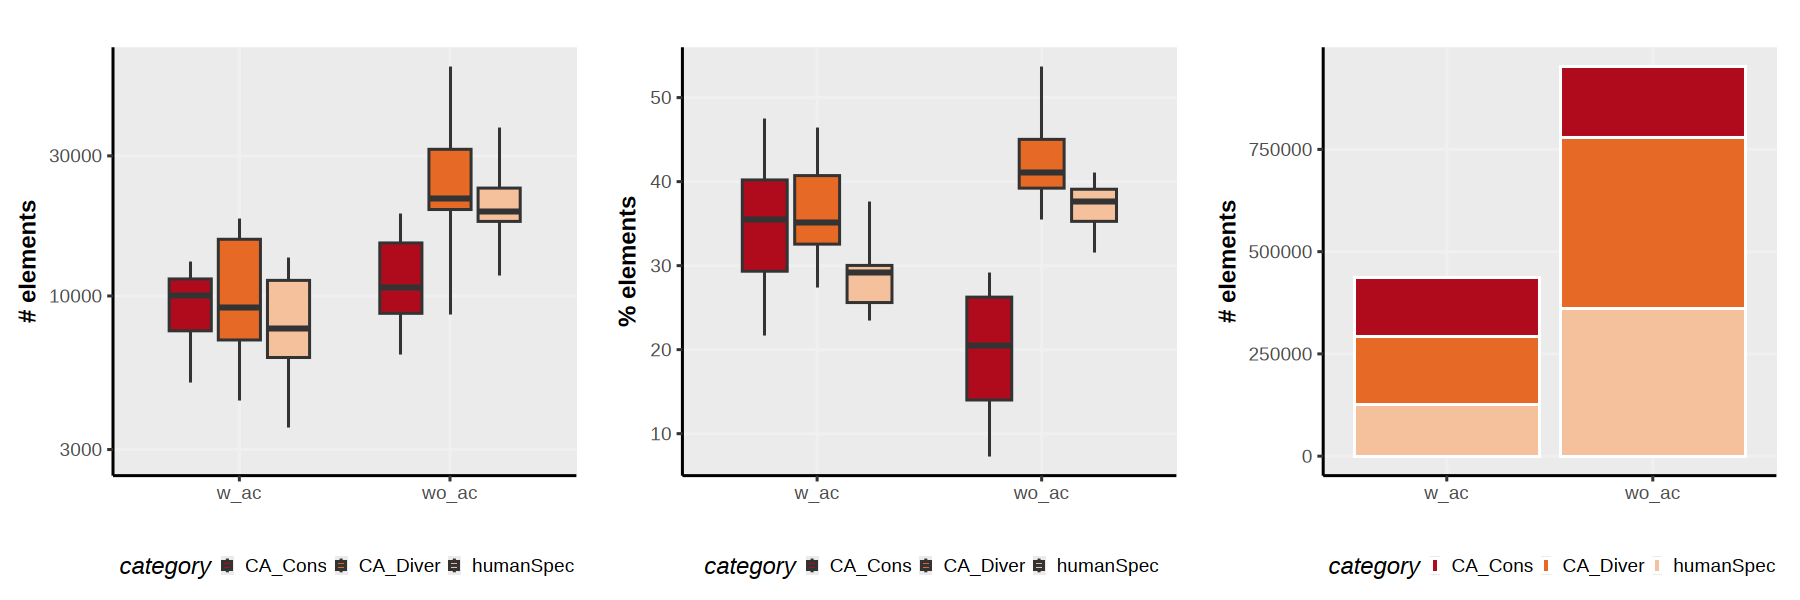

In [26]:
t1 <- lca %>%
ggplot(aes(x = group, y = Freq, fill = category)) + 
geom_boxplot(width = 0.6, position = position_dodge(0.7), coef = 2, outlier.shape = NA) +
ylab("# elements") + xlab("") + 
theme_Publication() + scale_y_log10() + 
scale_fill_manual(values = c('#b00b1d', '#e66925', '#f5c09c', '#66646a'))

t2 <- lca %>% group_by(group, subclass.x) %>%
mutate(ratio = Freq/sum(Freq)) %>% ungroup %>%
ggplot(aes(x = group, y = 100*ratio, fill = category)) + 
geom_boxplot(width = 0.6, position = position_dodge(0.7), coef = 2, outlier.shape = NA) +
ylab("% elements") + xlab("") + 
theme_Publication() +
scale_fill_manual(values = c('#b00b1d', '#e66925', '#f5c09c', '#66646a'))

### without separating cell class
t3 <- lca %>% group_by(group, category) %>%
summarise(Freq = sum(Freq)) %>% 
ungroup() %>%
ggplot(aes(x = group, y = Freq, fill = category)) + 
geom_col(color = "white") +
ylab("# elements") + xlab("") + 
theme_Publication() + 
scale_fill_manual(values = c('#b00b1d', '#e66925', '#f5c09c', '#66646a'))

options(repr.plot.width = 15, repr.plot.height = 5)
fig1 <- cowplot::plot_grid(t1, t2, t3, ncol = 3)
fig1

## Check Phastcons conservation for comparsion

Using V2 as id variables



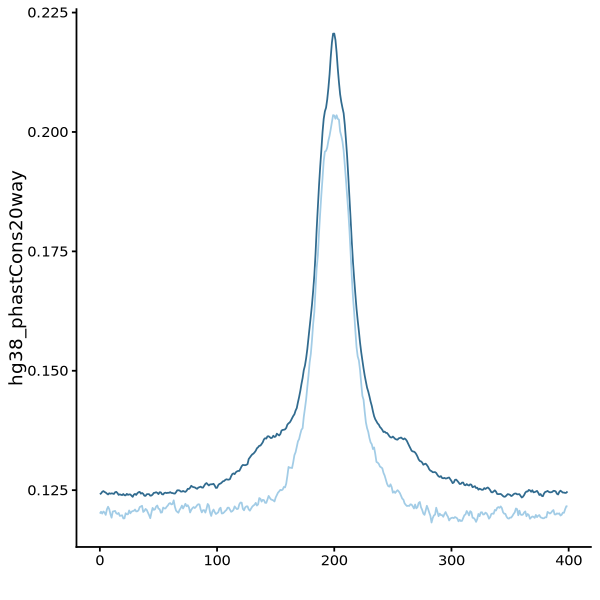

In [29]:
tprofile <- read.table("cCREs_w_H3K27ac_chmm/phastCons//hg38_phastCons20way_k27ac_stratify_profile.txt", sep = '\t', skip = 2)
t1 <- tprofile[,-1] %>% reshape2::melt() %>%
mutate(variable = as.integer(gsub("V", "", variable))-3) %>%
ggplot(aes(x = variable, y= value, color = V2)) + 
geom_line() + xlab("") + ylab("hg38_phastCons20way") + 
theme_classic() + NoLegend() + 
scale_color_manual(values = c("#316b8f", "#a2cce6")) 

options(repr.plot.width = 5, repr.plot.height = 5)
t1

## Motifs analysis for H3K27ac+ / H3K27ac- cCREs

In [22]:
### read motif clustering results
### read motif finding results from homer
mclass <- read.table("/projects//ps-renlab2/y2xie/projects/genome_ref/241102_JASPAR2022/240722_WE_JASPAR_2022_monaLisa_Dump_noPseudo_thresh0.7_annotated.txt", header = T)

### H3K27ac+
motif <- list()
for (f in match_name4){ 
    tmp <- read.csv(paste0("motif/", f, "_w_H3K27ac/knownResults.txt"), sep = "\t", row.names = 1) %>%
    setNames(c("consensus", "p_value", "log_p_value", "fdr", "tgt_num", "tgt_pct", "bgd_num", "bgd_pct")) %>%
    tibble::rownames_to_column("motif") %>% mutate(celltype = f)
    tmp$mclass <- mclass[match(tmp$motif, mclass$JASPER),]$Cluster_name
    
    motif[[f]] <- tmp
}

vmotif2 <- do.call(rbind, motif) %>% 
group_by(celltype) %>% 
slice_min(order_by = log_p_value, n = 5) %>% 
ungroup() %>%
dplyr::select(motif) %>% unlist %>% unique
    
rmat2 <- do.call(rbind, motif) %>%
reshape2::dcast(celltype ~ motif, value.var = "p_value") %>%
tibble::column_to_rownames("celltype")
rmat2[is.na(rmat2)] <- 1
rmat2 <- -log10(rmat2)
max_val <- max(rmat2[is.finite(as.matrix(rmat2))], na.rm = TRUE)
rmat2[] <- lapply(rmat2, function(x) replace(x, !is.finite(x), max_val))
rmat2[rmat2 > 30] <- 30

In [23]:
### H3K27ac-
motif <- list()
for (f in match_name4){ 
    tmp <- read.csv(paste0("motif/", f, "_wo_H3K27ac/knownResults.txt"), sep = "\t", row.names = 1) %>%
    setNames(c("consensus", "p_value", "log_p_value", "fdr", "tgt_num", "tgt_pct", "bgd_num", "bgd_pct")) %>%
    tibble::rownames_to_column("motif") %>% mutate(celltype = f)
    tmp$mclass <- mclass[match(tmp$motif, mclass$JASPER),]$Cluster_name
    
    motif[[f]] <- tmp
}

vmotif3 <- do.call(rbind, motif) %>% 
group_by(celltype) %>% 
slice_min(order_by = log_p_value, n = 5) %>% 
ungroup() %>%
dplyr::select(motif) %>% unlist %>% unique
    
rmat3 <- do.call(rbind, motif) %>%
reshape2::dcast(celltype ~ motif, value.var = "p_value") %>%
tibble::column_to_rownames("celltype")
rmat3[is.na(rmat3)] <- 1
rmat3 <- -log10(rmat3)
max_val <- max(rmat3[is.finite(as.matrix(rmat3))], na.rm = TRUE)
rmat3[] <- lapply(rmat3, function(x) replace(x, !is.finite(x), max_val))
rmat3[rmat3 > 30] <- 30

In [359]:
smat3 <- rmat3[match_name4, unique(c(vmotif2, vmotif3))] %>% t
max_indices <- max.col(smat3)
permutation_vector <- order(max_indices)
smat3 <- smat3[permutation_vector, ]

smat2 <- rmat2[match_name4, rownames(smat3)] %>% t

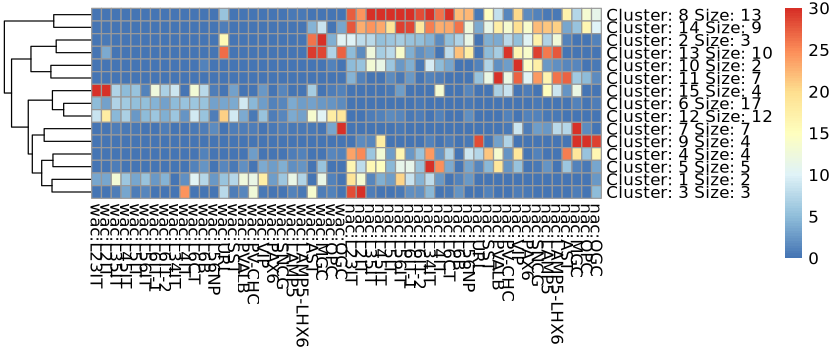

In [369]:
qmtx <- cbind(smat2, smat3) %>% as.data.frame %>%
setNames(c(paste0("wac:", colnames(smat2)), paste0("nac:", colnames(smat3)))) 

kn <- 15
set.seed(921)

options(repr.plot.width = 7, repr.plot.height = 3)
d1 <- qmtx %>% 
pheatmap(cluster_cols = F, cluster_rows = T, kmeans_k = kn)

qorder <- d1$kmeans$cluster %>% as.data.frame %>%
setNames("kmeansk") %>% 
mutate(kmeansk = factor(kmeansk, levels = c(15, 6, 12, 1, 3, 8, 14, 4, 5, 2, 13, 11, 10, 7, 9))) %>%
arrange(kmeansk)

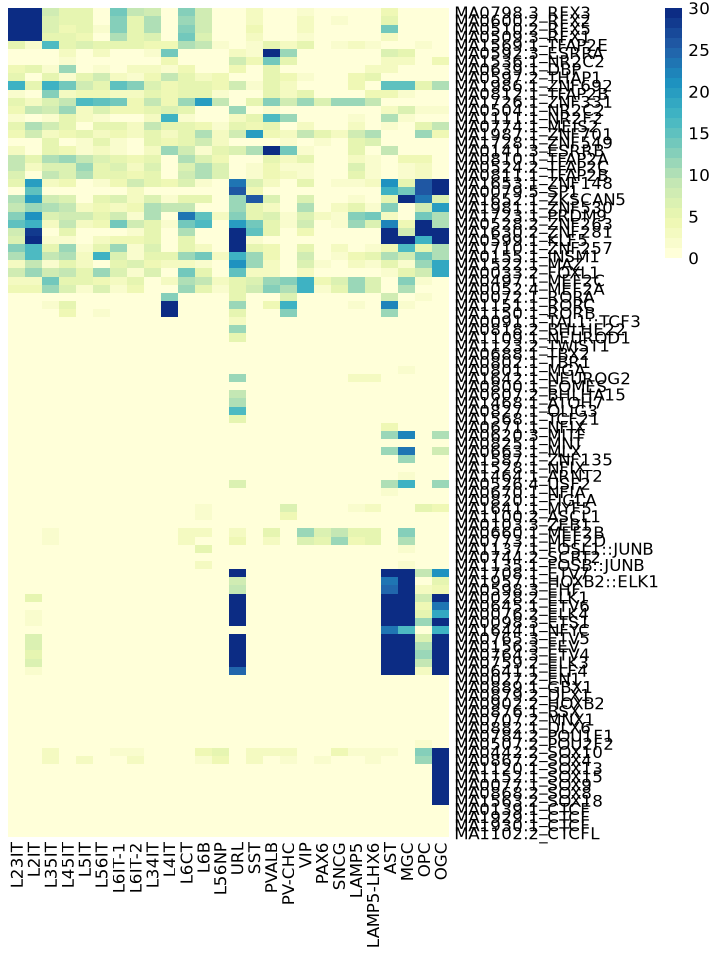

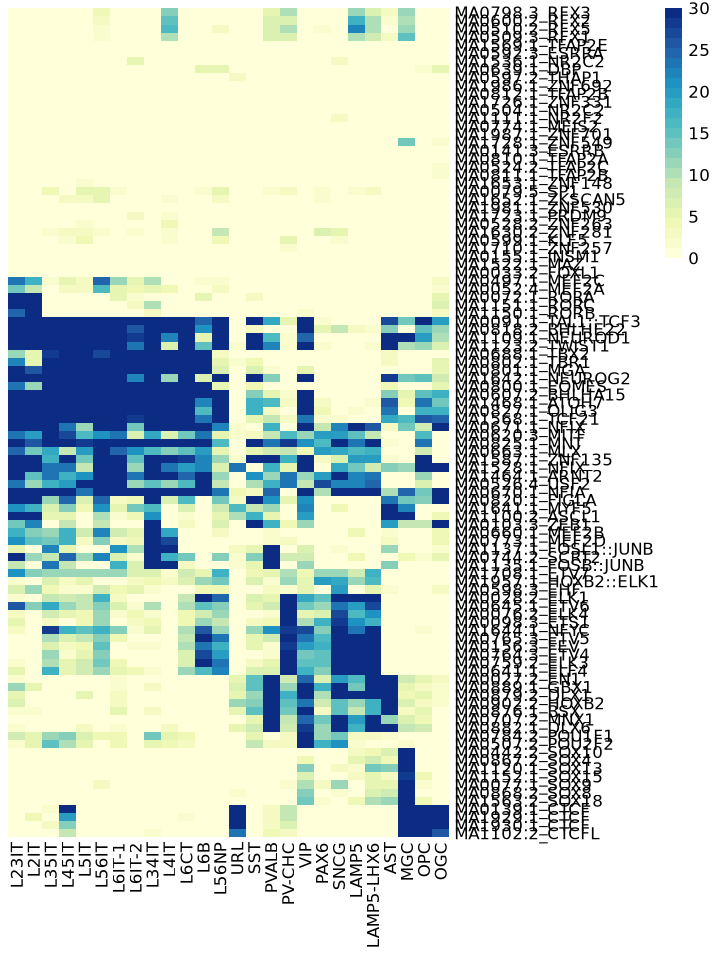

In [371]:
options(repr.plot.width = 6, repr.plot.height = 8)
fig1 <- smat2[rownames(qorder),] %>% 
pheatmap(cluster_cols = F, cluster_rows = F, # gaps_row = cumsum(table(qorder$kmeansk)), 
             border_color = NA, show_colnames = T, 
         angle_col = 90, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

fig2 <- smat3[rownames(qorder),] %>% 
pheatmap(cluster_cols = F, cluster_rows = F, # gaps_row = cumsum(table(qorder$kmeansk)), 
             border_color = NA, show_colnames = T, 
         angle_col = 90, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

In [111]:
cmtx <- read.csv("../07.cCREs/MiniAtlas_H3K27ac_snATAC_whole.union.peaks_250722.subclass_corrected.cpm.csv", row.names = 1)
colnames(cmtx) <- gsub("\\.", "-", colnames(cmtx))

rmtx <- read.table("../04.clustering/02.RNA/MiniAtlas_RNA_merged_dual_filt_clean_250724.subclass.rpkm.txt", 
                   sep = "\t", check.names = F)

hg38 <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed")
# hg38m <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/refdata-cellranger-GRCh38.p13_v43/GRCh38/genes/tss_1500bp.bed")

### retain only one gene per  entry
set.seed(921)

tmp1 <- hg38 %>% filter(!(V6 %in% hg38[duplicated(hg38$V6),]$V6))
tmp2 <- hg38 %>% filter(V6 %in% hg38[duplicated(hg38$V6),]$V6) %>%
filter(V1 %in% paste0("chr", c(1:22,"X"))) %>% 
group_by(V6) %>%
slice_sample(n = 1) %>%
ungroup %>% as.data.frame

hg38 <- rbind(tmp1, tmp2)

### provide also 500bp as ccre
hg38t <- hg38 %>% 
mutate(start = ifelse(V4 == "+", V2-251, V3-251)) %>%
mutate(end = ifelse(V4 == "+", V2+250, V3+250)) %>%
mutate(V2 = start, V3 = end) %>%
dplyr::select(V1, V2, V3, V4, V5, V6)

In [137]:
### cannot accurately quantify which TSS it is
badgene <- hg38t %>%
mutate(range = paste0(V1, ":", V2, "-", V3)) %>%
group_by(range) %>%
filter(n() > 1) %>%
ungroup() %>% dplyr::select(V6, range)

In [123]:
write.table(hg38t, "/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/refdata-cellranger-GRCh38.p13_v43/GRCh38/genes/tss_500bp_single.bed",
            sep = "\t", quote = F, row.names = F, col.names = F)

In [157]:
hg38tm <- read.csv('MiniAtlas_H3K27ac_500bp_tss_single_250722.subclass_corrected.cpm.csv') #, row.names = 1)
colnames(hg38tm) <- gsub("\\.", "-", colnames(hg38tm))

hg38tm <- hg38tm %>% distinct() %>%
tibble::column_to_rownames("X")

hg38tm <- hg38tm[grep("^chr", rownames(hg38tm)),]
hg38tm <- hg38tm[grep(paste0(c("chrY", "chrM"), collapse = "|"), rownames(hg38tm), invert = T),]

hg38tm[,c("V1", "V2", "V3")] <- stringr::str_split_fixed(rownames(hg38tm), pattern = "[-:]", n = 3)
prange <- GenomicRanges::GRanges(hg38tm[, "V1"], IRanges::IRanges(as.integer(hg38tm[, "V2"]), as.integer(hg38tm[, "V3"]))) 

In [159]:
### Output GEX: chr'\t'start'\t'end'\t'name'\t'rpkm'\t'strand
# tmp <- merge(rmtx, hg38, by.x = 0, by.y = "V6") 
# for (f in colnames(rmtx)){
#     write.table(tmp[, c("V1", "V2", "V3", "Row.names", f, "V4")], 
#                 paste0("../08.conns/abc/", f, "/gex.rpkm"), sep = "\t", quote = F, row.names = F, col.names = F)
# }

### output activity: sqrt(H3K27ac*ATAC): chr'\t'start'\t'end'\t'signal 
### also include promoter sequence!
tmp <- cmtx
tmp[,c("V1", "V2", "V3")] <- stringr::str_split_fixed(rownames(cmtx), pattern = "[-:]", n = 3)
for (f in colnames(cmtx)){
    qct <- pair_df[pair_df$MiniAtlas == f, "YELi"]
    if (!is.na(qct)){
        ccre <- read.table(paste0("../07.cCREs/cCREs/subclass/", qct, ".bed")) %>% mutate(V6 = paste0(V1, ":", V2, "-", V3))
        ccrange <- GenomicRanges::GRanges(ccre[, 1], IRanges::IRanges(as.integer(ccre[, 2]), as.integer(ccre[, 3])))
        
        ### force inclusion of all promoter region? 
        idx <- S4Vectors::subjectHits(GenomicRanges::findOverlaps(ccrange, prange)) %>% unique ### already included in ccre matrix
        qrange1 <- hg38tm[-idx, ]
        qrange1$name <- rownames(qrange1)
        qrange2 <- tmp[ccre$V6, ]
        qrange2$name <- ccre[match(rownames(qrange2), ccre$V6), "V4"]
        qrange <- rbind(qrange1, qrange2)
        write.table(qrange[, c("V1", "V2", "V3", f)], 
                    paste0("../08.conns/abc/", f, "/H3K27ac.tssinclu.cpm"), sep = "\t", quote = F, row.names = F, col.names = F)

#         arange <- atac[rownames(qrange), ]
#         qrange[,f] <- sqrt(qrange[,f] * arange[,qct]) ### ATAC + H3K27ac
#         write.table(qrange[, c("V1", "V2", "V3", f)], 
#                     paste0("../08.conns/abc/", f, "/activity.cpm"), sep = "\t", quote = F, row.names = F, col.names = F)
    }
}

### Write Q / raw cool from snm3c

In [303]:
pair_df2 <- read.table("../06.integration/snm3c_DPT_RNA_250601.pred_subclass_match.txt", header = T) %>%
mutate(snm3c = ifelse(MiniAtlas == "MSN", "MSN", snm3c)) %>%
mutate(snm3c = gsub("-", "_", snm3c)) %>%
mutate(snm3c = gsub("/", "", snm3c)) %>%
filter(!is.na(snm3c))

pair_df2$MiniAtlas %>% unique %>% length
pair_df2 %>% nrow

[1] 32

[1] 32

In [438]:
ffile <- list.files(paste0("../../ref/hba_snm3c/hic/Q/"))
ffile2 <- list.files(paste0("../../ref/hba_snm3c/hic/raw/"))
for (f in pair_df2$MiniAtlas){
    ct <- pair_df2[pair_df2$MiniAtlas == f, ]$snm3c
    ctf <- paste0(ct, ".hic")
    system(paste0("ln -sf /tscc/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/hic/Q/", ctf, " /tscc/projects/ps-renlab2/y2xie/projects/BICAN/analysis/08.conns/abc/", f, "/impute.hic"))
    
    ctf <- paste0(ct, ".raw.hic")
    system(paste0("ln -sf /tscc/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/hic/raw/", ctf, " /tscc/projects/ps-renlab2/y2xie/projects/BICAN/analysis/08.conns/abc/", f, "/raw.hic"))
}

In [425]:
pair_df3 <- merge(pair_df, pair_df2, by = "MiniAtlas") %>% mutate(snm3c = ifelse(snm3c == "Chd7", "CHD7", snm3c))
write.table(pair_df3, "../06.integration/snm3c_snATAC_DPT_RNA_250601.pred_subclass_match.txt", sep = "\t", quote = F, row.names = F, col.names = T)

## Check overlap with VSITA enhancer


In [300]:
## Check overlap with VSITA enhancer
vista <- read.table("/projects//ps-renlab2/y2xie/projects/genome_ref/vista_enhancer_2024_locus.tsv", header = T)
vista %>% filter(curation_status == "positive") %>% select(assembly) %>% table

assembly
          anoCar2           braFlo2           felCat9              hg38 
                1                 1                 1              1218 
             mm10 MPIMG_talOcc4v2.1           panTro6           xenTro9 
              882                 5                 3                 1 

In [301]:
gccod <- vista %>% filter(curation_status == "positive" & assembly == "hg38") %>% select(coordinate_hg38) %>% unique %>% unlist
gccod <- stringr::str_split_fixed(gccod, pattern = "[:-]", n = 3) %>% as.data.frame
gccod <- gccod[grep("chr", gccod$V1),]
### generate GRange
gcrange <- GRanges(gccod[,1], ranges = IRanges(as.numeric(gccod[,2]), as.numeric(gccod[,3])))

In [302]:
### exclude promoter proximal cCREs
prange <- GenomicRanges::GRanges(hg38t[, 1], IRanges::IRanges(as.integer(hg38t[, 2]), as.integer(hg38t[, 3])))

In [21]:
### Try to intersect to see which one is more enriched...?
### check only distal element
wacrange <- GRanges(sig[,1], ranges = IRanges(as.numeric(sig[,2]), as.numeric(sig[,3])))
nacrange <- GRanges(nonsig[,1], ranges = IRanges(as.numeric(nonsig[,2]), as.numeric(nonsig[,3])))

idx <- queryHits(findOverlaps(wacrange, prange)) %>% unique
idy <- queryHits(findOverlaps(nacrange, prange)) %>% unique

wacrange <- GRanges(sig[-idx,1], ranges = IRanges(as.numeric(sig[-idx,2]), as.numeric(sig[-idx,3])))
nacrange <- GRanges(nonsig[-idy,1], ranges = IRanges(as.numeric(nonsig[-idy,2]), as.numeric(nonsig[-idy,3])))

### compare to random
### generate random bed by shuffle
write.table(rbind(sig, nonsig)[,1:3], "tmp.bed", sep = "\t", row.names = F, col.names = F, quote = F)
system("bedtools shuffle -i tmp.bed -g /projects/ps-renlab2/y2xie/projects/genome_ref/hg38.main.chrom.sizes -excl /projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/hg38-blacklist.v2.bed -noOverlapping -seed 921 > tmp_shuffle.bed")
sfbed <- read.table("tmp_shuffle.bed.bed")
sfrange <- GRanges(sfbed[,1], ranges = IRanges(as.numeric(sfbed[,2]), as.numeric(sfbed[,3])))

w0 <- queryHits(findOverlaps(sfrange, gcrange)) %>% unique %>% length
g0 <- subjectHits(findOverlaps(sfrange, gcrange)) %>% unique %>% length
w1 <- queryHits(findOverlaps(wacrange, gcrange)) %>% unique %>% length
g1 <- subjectHits(findOverlaps(wacrange, gcrange)) %>% unique %>% length
w2 <- queryHits(findOverlaps(nacrange, gcrange)) %>% unique %>% length
g2 <- subjectHits(findOverlaps(nacrange, gcrange)) %>% unique %>% length
cting <- matrix(data = c(w0,(w1+w2),w1, w2, 
                         nrow(sfbed)-w0, length(c(sig$range, nonsig$range))-(w1+w2), length(sig$range)-w1, length(nonsig$range)-w2), 
                nrow = 4, ncol = 2)
cdf <- list()
for (i in c(2:4)){
    cdf[[i]] <- data.frame(pvalue = fisher.test(cting[c(i,1),])$p.value, or = fisher.test(cting[c(i,1),])$estimate) 
}
cdf <- do.call(rbind, cdf)
cdf$group <- c("all cCREs", "with ac", "no ac")

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


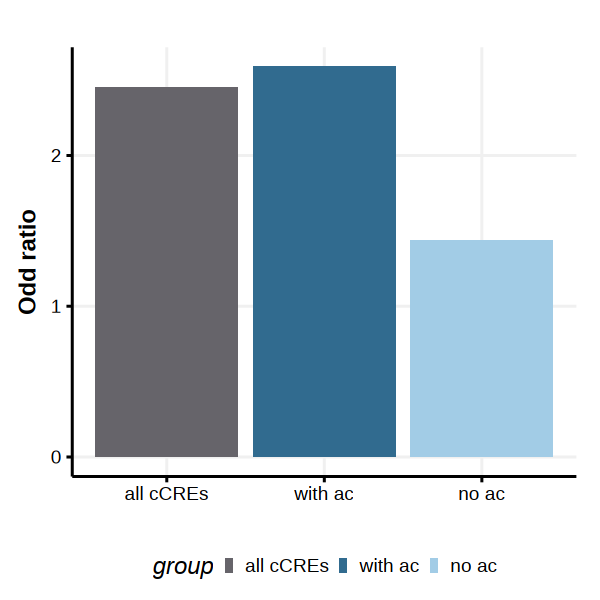

In [22]:
options(repr.plot.width = 5, repr.plot.height = 5)
t1 <- cdf %>%
mutate(group = factor(group, levels = c("all cCREs", "with ac", "no ac"))) %>%
ggplot(aes(x = group, y = or, fill = group)) + 
geom_col() + ylab("Odd ratio") + xlab("") + 
theme_Publication() + 
scale_fill_manual(values = c('#66646a', "#316b8f", "#a2cce6")) 
     
t1

## Annotate H3K27me3+ cCREs using chromatin states

In [16]:
qct <- read.table("cCREs_w_H3K27ac_chmm/subclass_to_analyze.list") %>% select(V1) %>% unlist %>% as.character
clist <- list()
for (fname in qct){
    f <- paste0(fname, "_hba.whole.union.peaks.anno.bed")
    # ct2 <- pair_df[pair_df$MiniAtlas == fname,]$YELi
    if (file.exists(paste0("../10.chromhmm/output/DNAme_hyperCGN/annotation/", f))){
        clist[[fname]] <- read.table(paste0("../10.chromhmm/output/DNAme_hyperCGN/annotation/", f))
    }
}

length(clist) ### MSN are removed

[1] 26

In [17]:
df <- lapply(clist, function(x) data.frame(pf = length(which(x$V5 %in% c("E1", "E2"))), 
                                           npf = length(which(x$V5 %in% c("E8", "E7", "E6", "E3", "E4", "E5", "E9")))))
df <- do.call(rbind, df)
df$celltype <- names(clist)

In [37]:
system("mkdir cCREs_w_H3K27me3_chmm")
for (fname in names(clist)){
    tmp <- clist[[fname]]
    tmp <- tmp %>% mutate(range = paste0(V1, ":", V2, "-", V3)) %>%
    filter(V5 %in% c("E1", "E2")) %>% 
    mutate(V8 = "w_me3") %>%
    select(V1, V2, V3, V4, range, V5, V8)
    write.table(tmp, paste0("cCREs_w_H3K27me3_chmm/", fname, "_H3K27me3_anno.bed"), 
                row.names = F, col.names = F, sep = "\t", quote = F)
}

## Plot H3K27me3+ cCREs

In [4]:
cpm <- read.csv("../07.cCREs/MiniAtlas_H3K27me3_snATAC_whole.union.peaks_250722.subclass_corrected.cpm.csv", row.names = 1, header = T)
colnames(cpm) <- gsub("\\.", "-", colnames(cpm))

In [5]:
ccre <- list()
for (fname in qct){
    f <- paste0(fname, "_H3K27me3_anno.bed")
    ccre[[fname]] <- read.table(paste0("../07.cCREs/cCREs_w_H3K27me3_chmm/", f))
}
ccre <- do.call(rbind, ccre) %>% select(V1, V2, V3, V4, V5) %>% distinct
nrow(ccre)

[1] 150372

In [6]:
smat <- log2(cpm[ccre$V5, qct] + 1)

In [3]:
t1 <- read.table(paste0("cCREs_w_H3K27me3_chmm/nmf/res/peaks.entropy.sta.txt")) %>%
tibble::column_to_rownames("V1") %>% t %>% as.data.frame %>%
arrange(Median, Mean) %>% head(3)

t2 <- read.table(paste0("cCREs_w_H3K27me3_chmm/nmf/res/peaks.sparseness.sta.txt")) %>%
tibble::column_to_rownames("V1") %>% t %>% as.data.frame %>%
arrange(desc(Median), desc(Mean)) %>% head(3)

intersect(t1$rank, t2$rank)

[1] 19 18 17

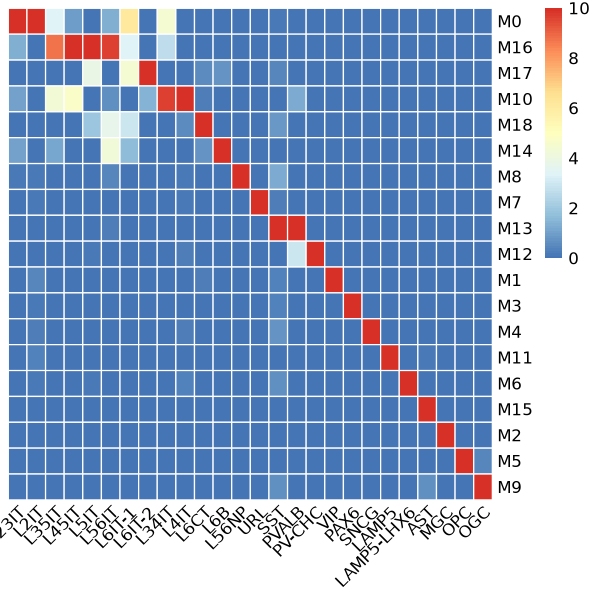

In [11]:
### use nmf to order cCREs for plotting
bestres <- max(intersect(t1$rank, t2$rank))
nmf <- read.table(paste0("../07.cCREs/cCREs_w_H3K27me3_chmm/nmf/res/peaks.r", bestres, "n10.statW"))
mx <- read.table(paste0("../07.cCREs/cCREs_w_H3K27me3_chmm/nmf/res/peaks.r", bestres, "n10.H.mx"), sep = "\t")

rownames(mx) <- paste0("M", 0:max(unique(nmf$V3)))
colnames(mx) <- read.table(paste0("../07.cCREs/cCREs_w_H3K27me3_chmm/nmf/peaks.ygi")) %>% dplyr::select(V1) %>% unlist %>% as.character

max_indices <- max.col(mx[, match_name4])
permutation_vector <- order(max_indices)
olist <- mx[permutation_vector, match_name4]

options(repr.plot.width = 5, repr.plot.height = 5)
olist %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 45,
         border_color = "white", show_rownames = T, breaks = seq(0, 10, 0.1)) 

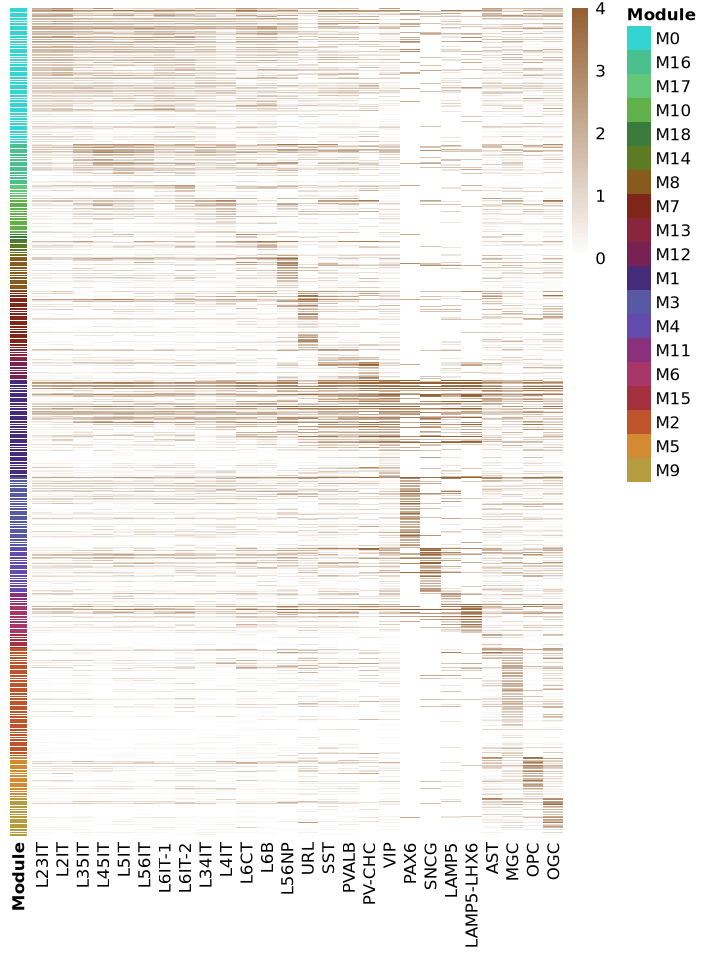

In [13]:
clevel <- c("M0", setdiff(rownames(olist), "M0"))
clevel <- gsub("M", "", clevel)

eorder <- distinct(nmf[, c("V1", "V3")]) %>% 
mutate(V3 = factor(V3, levels = clevel)) %>%
arrange(V3) %>% dplyr::select(V1) %>% unlist %>% as.character # %>% unique

canno1 <- distinct(nmf[, c("V1", "V3")]) %>% dplyr::select(V1, V3) %>% distinct %>%
tibble::column_to_rownames("V1") %>%
mutate(V3 = paste0("M", V3)) %>%
dplyr::select(V3) %>% setNames("Module") %>%
mutate(Module = factor(Module, levels = paste0("M", clevel)))

rannocolor <- sorted_colors[1:length(unique(canno1$Module))]
names(rannocolor) <- levels(canno1$Module)
rannocolor <- list(Module = rannocolor)

options(repr.plot.width = 6, repr.plot.height = 8)
t1 <- smat[eorder, match_name4] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, 
         annotation_row = canno1, annotation_colors = rannocolor,
         border_color = NA, show_rownames = F, breaks = seq(0, 4, 0.08), 
         color = colorRampPalette(c("white", "#956134"))(50))

## Check genomic annotation

Warning message in geom_bar(width = 1, stat = "identity", color = "white", size = 0.5):
“Ignoring unknown parameters: `size`”


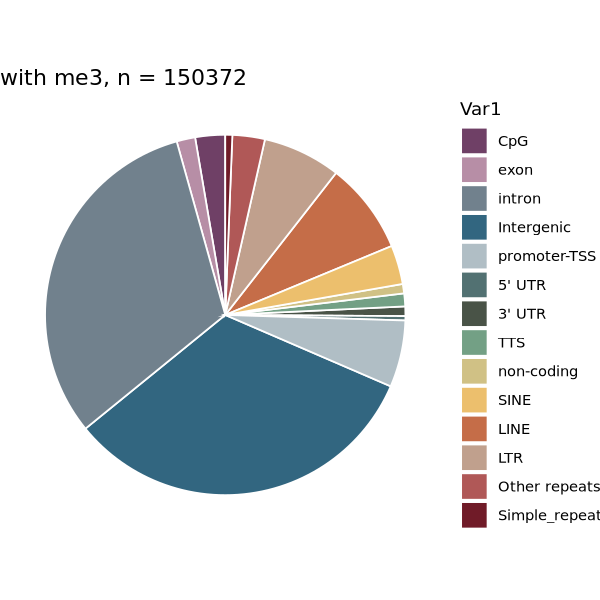

In [221]:
qlevel <- c('CpG', 'exon ', 'intron ', 'Intergenic', 'promoter-TSS ', '5\' UTR ', '3\' UTR ', 'TTS ', 'non-coding ', 'SINE', 'LINE', 'LTR', 'Other repeats', 'Simple_repeat')
t1 <- sum_detailed_anno(anno[anno$range %in% eorder,]) %>%
mutate(Var1 = factor(Var1, levels = qlevel)) %>%
ggplot(aes(x = "", y = Freq, fill = Var1)) +
geom_bar(width = 1, stat = "identity", color = "white", size = 0.5) +
coord_polar(theta = "y") + 
theme_void() + ggtitle(paste0("with me3, n = ", length(eorder))) + 
scale_fill_manual(values = colfunc(14))

options(repr.plot.width = 5, repr.plot.height = 5)
t1

## Check repressive gene: gene with promoter classified as H3K27me3+ 

In [176]:
prange <- GenomicRanges::GRanges(hg38t[,1], IRanges::IRanges(as.integer(hg38t[, 2]), as.integer(hg38t[, 3])), gene = hg38t[,7])
    
tmp <- stringr::str_split_fixed(eorder, pattern = "[:-]", n = 3)
crange1 <- GenomicRanges::GRanges(tmp[, 1], IRanges::IRanges(as.integer(tmp[, 2]), as.integer(tmp[, 3])))
govlp <- findOverlapPairs(prange, crange1) %>% as.data.frame %>% 
mutate(range = paste0(second.seqnames, ":", second.start, "-", second.end)) %>%
dplyr::select(range, first.X.gene) %>% distinct

head(govlp, 3)

,range,first.X.gene
,<chr>,<chr>
1,chr1:911068-911567,ENSG00000230699
2,chr1:920991-921490,LINC02593
3,chr1:923602-924101,SAMD11


In [231]:
glist <- list()
for (file in list.files("cCREs_w_H3K27me3_chmm/", pattern = '_H3K27me3_anno.bed')){
    fname <- gsub("_H3K27me3_anno.bed", "", file)
    f <- read.table(paste0("cCREs_w_H3K27me3_chmm/", file)) %>% 
    filter(V7 == 'w_me3') 
    glist[[fname]] <- merge(f, govlp, by.x = "V5", by.y = "range")   
}

In [239]:
### Run Gene ontology analysis
qlist <- qlist2 <- list()
for (f in names(glist)){ 
    qqgene <- glist[[f]] %>% dplyr::select(first.X.gene) %>% unlist %>% as.character %>% unique
    qtable <- clusterProfiler::enrichGO(gene = qqgene,
                OrgDb = org.Hs.eg.db::org.Hs.eg.db,
                keyType = 'SYMBOL',
                ont = "BP", # molecule function
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)
    qlist[[f]] <- qtable@result %>% mutate(module = f) 
    qtable2 <- clusterProfiler::simplify(qtable, cutoff=0.7, by="p.adjust", select_fun=min)
    qlist2[[f]] <- qtable2@result %>% mutate(module = f) 
}

do.call(rbind, qlist2) %>%
dplyr::select(module) %>% table

module
       AST      L23IT       L2IT      L34IT      L35IT      L45IT       L4IT 
       309        263        300        293        337        338        361 
     L56IT      L56NP       L5IT        L6B       L6CT     L6IT-1     L6IT-2 
       353        405        364        370        400        281        339 
     LAMP5 LAMP5-LHX6        MGC        OGC        OPC       PAX6     PV-CHC 
       309        260        317        383        309        167        384 
     PVALB       SNCG        SST        URL        VIP 
       388        272        431        421        406 

In [292]:
qterm0 <- do.call(rbind, qlist) %>% filter(p.adjust < 0.05) %>%
select(Description) %>% table %>% as.data.frame %>%
filter(Freq >= 12) %>% select(Description) %>% unlist %>% as.character

In [293]:
qterm1 <- do.call(rbind, qlist2) %>%
filter(Description %in% qterm0) %>%
group_by(module) %>% 
slice_max(-log10(p.adjust), n = 2) %>%
ungroup %>%
select(Description) %>% unlist %>% unique

qterm2 <- do.call(rbind, qlist2) %>%
filter(!(Description %in% qterm0)) %>%
group_by(module) %>% 
slice_max(-log10(p.adjust), n = 1) %>%
ungroup %>%
select(Description) %>% unlist %>% unique

tmp <- do.call(rbind, qlist) %>%
reshape2::dcast(Description ~ module, value.var = "p.adjust", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description")
tmp[is.na(tmp)] <- 1

ttp1 <- -log2(tmp[c(qterm1, qterm2), match_name4])

lmat1 <- tmp
lmat1 <- ifelse(lmat1 < 0.05, "*", "")

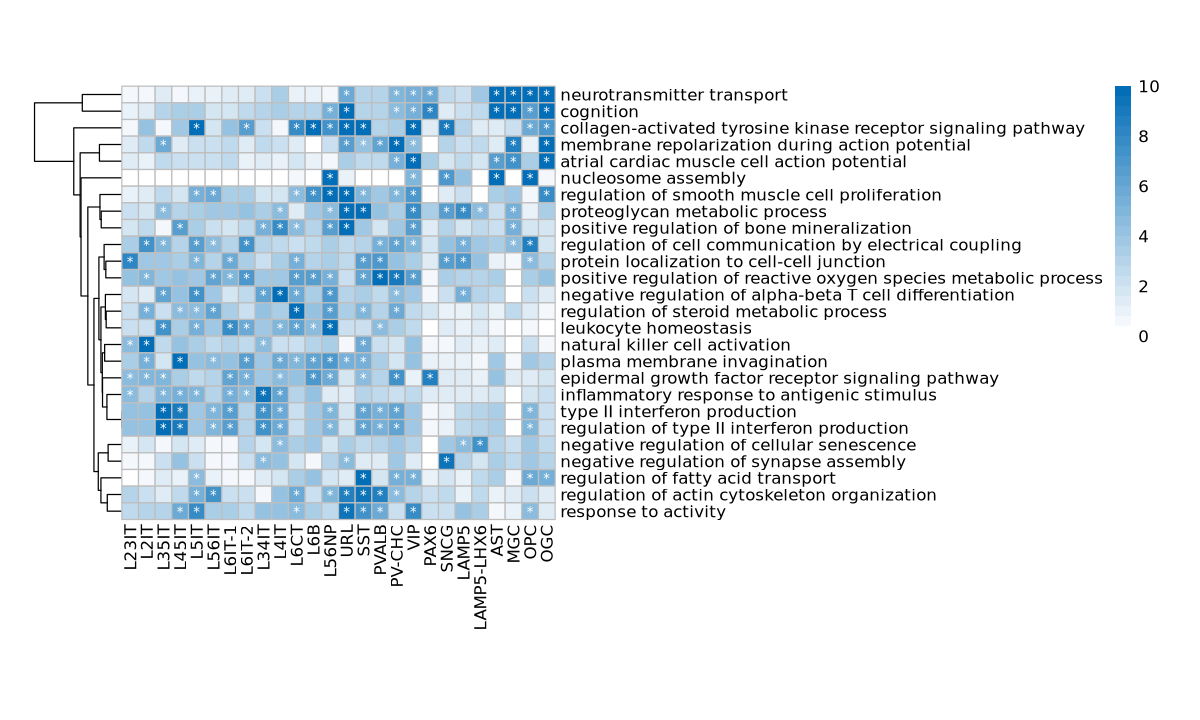

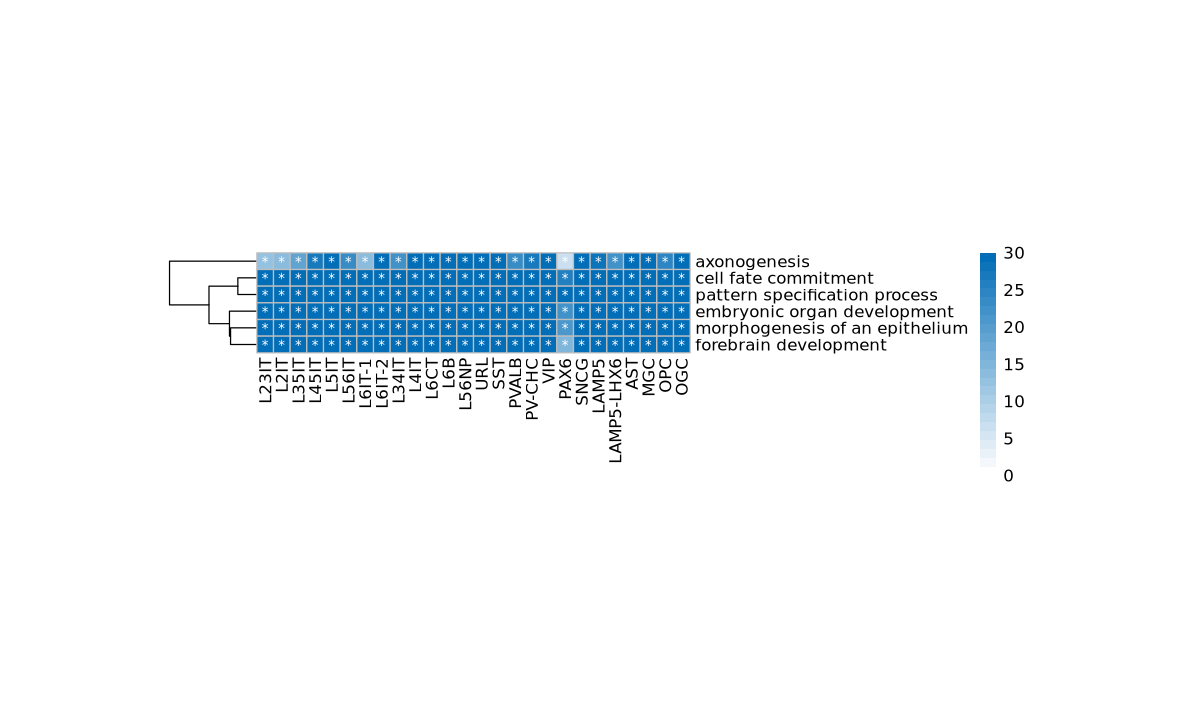

In [294]:
options(repr.plot.width = 10, repr.plot.height = 6)
t1 <- ttp1[qterm2, ] %>% 
pheatmap(cluster_cols = F, cluster_rows = T, 
         border_color = "gray", show_rownames = T,
         angle_col = 90, cellwidth = 10, cellheight = 10, breaks = seq(0, 10, 0.4), 
         display_numbers = lmat1[qterm2, colnames(ttp1)], number_color = "white",
         color = colorRampPalette(c("white", "#036EB8"))(25))

t2 <- ttp1[qterm1, ] %>% 
pheatmap(cluster_cols = F, cluster_rows = T, 
         border_color = "gray", show_rownames = T,
         angle_col = 90, cellwidth = 10, cellheight = 10, breaks = seq(0, 30, 1.2), 
         display_numbers = lmat1[qterm1, colnames(ttp1)], number_color = "white",
         color = colorRampPalette(c("white", "#036EB8"))(25))

## Check motif enriched in H3K27me3+ cCREs

In [129]:
motif <- list()
for (f in match_name4){ 
    tmp <- read.csv(paste0("motif/", f, "_H3K27me3_anno/knownResults.txt"), sep = "\t", row.names = 1) %>%
    setNames(c("consensus", "p_value", "log_p_value", "fdr", "tgt_num", "tgt_pct", "bgd_num", "bgd_pct")) %>%
    tibble::rownames_to_column("motif") %>% mutate(celltype = f)
    
    tmp$mclass <- mclass[match(tmp$motif, mclass$JASPER),]$Cluster_name
    motif[[paste0(f)]] <- tmp
}

### Plot strongest motifs first
lmotif1 <- do.call(rbind, motif) %>%
filter(fdr < 0.01) %>%
group_by(celltype, mclass) %>% 
slice_max(order_by = -log_p_value, n = 2) %>%
# slice_sample(n = 1) %>%
ungroup() %>%
dplyr::select(motif) %>% unlist %>% unique
lmotif1 <- lmotif1[!is.na(lmotif1)]

rmat1 <- do.call(rbind, motif) %>%
reshape2::dcast(celltype ~ motif, value.var = "p_value", fun.aggregate = min) %>%
tibble::column_to_rownames("celltype")
rmat1[is.na(rmat1)] <- 1
rmat1 <- -log10(rmat1)
rmat1[rmat1 > 10] <- 10

smat1 <- rmat1[match_name4, lmotif1] %>% t
max_indices <- max.col(smat1)
permutation_vector <- order(max_indices)
smat1 <- smat1[permutation_vector, ]

Warning message in .fun(.value[0], ...):
“no non-missing arguments to min; returning Inf”


In [139]:
### Label the strongest in each module
lmotif2 <- do.call(rbind, motif) %>%
filter(motif %in% lmotif1) %>%
group_by(celltype) %>% 
slice_max(order_by = -log_p_value, n = 2) %>%
ungroup() %>%
dplyr::select(motif) %>% unlist %>% unique

In [197]:
### Check motif class
library(JASPAR2022)
library(TFBSTools)

# Get all CORE motifs for human / mouse
human_motifs <- getMatrixSet(JASPAR2022::JASPAR2022, opts = list(species = "Homo sapiens")) #, collection = "CORE"))
hmotif <- do.call(rbind, lapply(human_motifs, function(x) data.frame(motif = x@ID, name = x@name, class = x@matrixClass)))

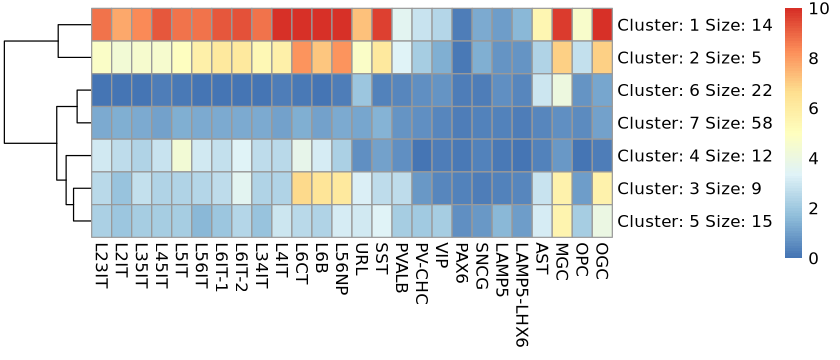

In [136]:
kn <- 7
set.seed(921)

options(repr.plot.width = 7, repr.plot.height = 3)
d1 <- smat1 %>% 
pheatmap(cluster_cols = F, cluster_rows = T, kmeans_k = kn)

qorder <- d1$kmeans$cluster %>% as.data.frame %>%
setNames("kmeansk") %>% # filter(kmeansk != 7) %>%
mutate(kmeansk = factor(kmeansk, levels = c(1, 2, 4, 3, 5, 6, 7))) %>%
arrange(kmeansk)

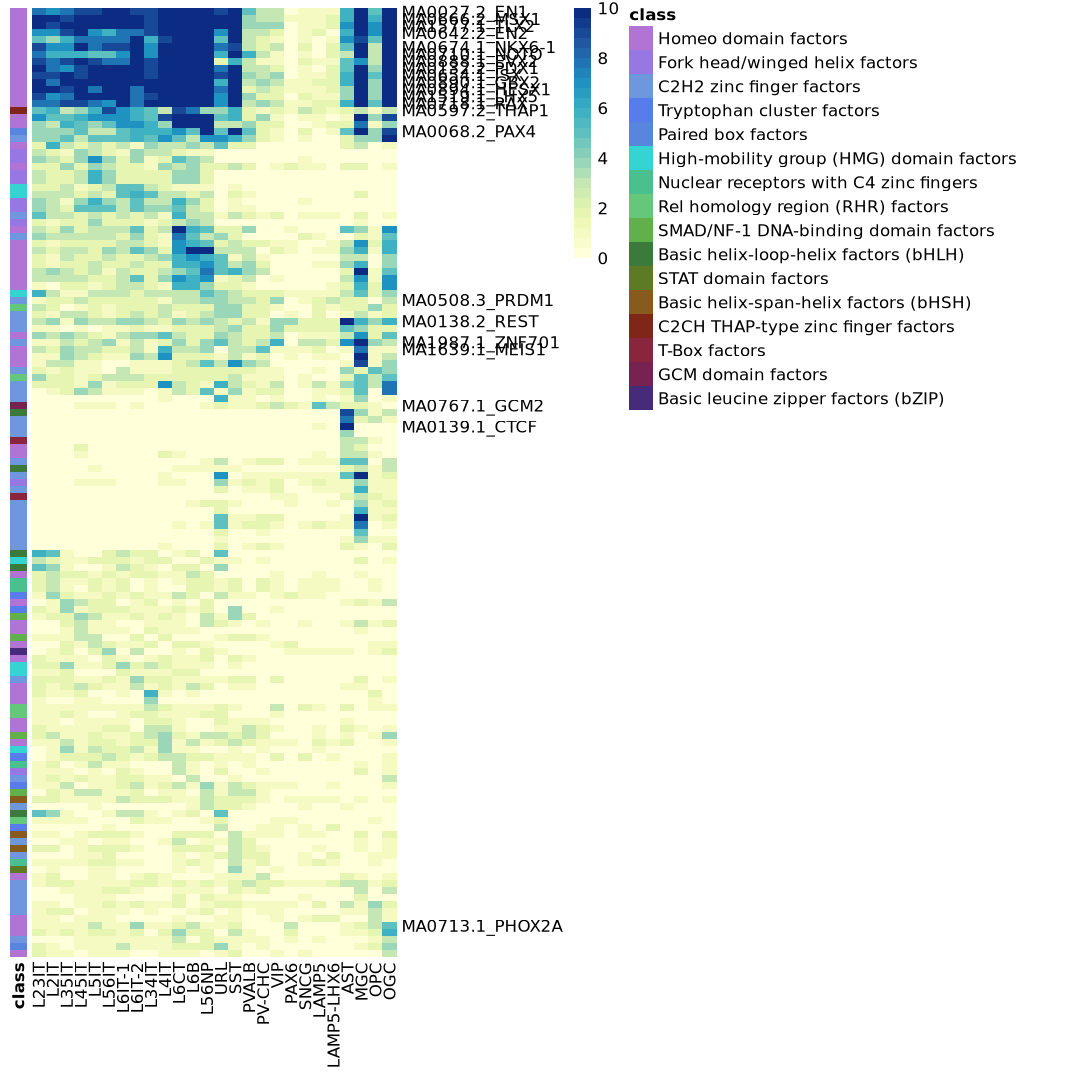

In [214]:
llabel <- rownames(qorder)
llabel[!(llabel %in% lmotif2)] <- ""

canno <- hmotif %>% mutate(id = paste0(motif, "_", name)) %>%
filter(id %in% rownames(qorder)) %>% 
select(id, class) %>% distinct %>%
group_by(id) %>% slice_sample(n = 1) %>% ungroup %>%
tibble::rownames_to_column("hold") %>%
tibble::column_to_rownames("id") %>%
select(class)

rannocolor <- sorted_colors[1:length(unique(canno$class))]
names(rannocolor) <- unique(canno$class)
rannocolor <- list(class = rannocolor)

options(repr.plot.width = 9, repr.plot.height = 9)
fig1 <- smat1[rownames(qorder),] %>% 
pheatmap(cluster_cols = F, cluster_rows = F,
         annotation_row = canno, annotation_colors = rannocolor, 
         border_color = NA,  labels_row = llabel, show_rownames = T,
         angle_col = 90, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



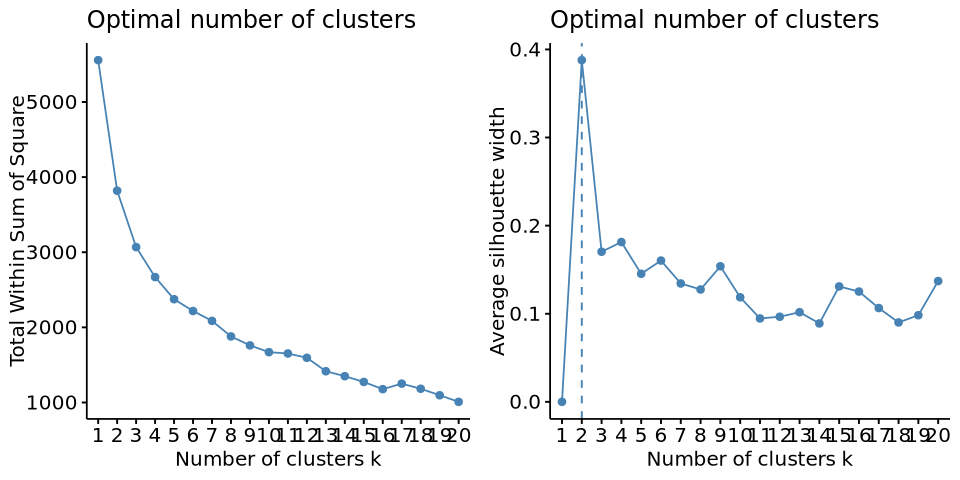

In [125]:
set.seed(921)
library(factoextra)
t1 <- fviz_nbclust(smat2, kmeans, k.max = 20, method = "wss")
t2 <- fviz_nbclust(smat2, kmeans, k.max = 20, method = "silhouette")

options(repr.plot.width = 8, repr.plot.height = 4)
cowplot::plot_grid(t1, t2, ncol = 2)

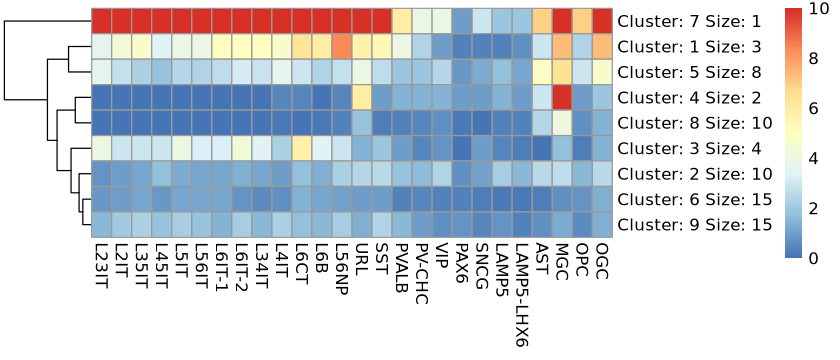

In [127]:
kn <- 9
set.seed(921)

options(repr.plot.width = 7, repr.plot.height = 3)
d1 <- smat2 %>% 
pheatmap(cluster_cols = F, cluster_rows = T, kmeans_k = kn)

qorder <- d1$kmeans$cluster %>% as.data.frame %>%
setNames("kmeansk") %>% # filter(kmeansk != 7) %>%
mutate(kmeansk = factor(kmeansk, levels = c(7, 3, 1, 5, 4, 8, 9, 6, 2))) %>%
arrange(kmeansk)

## Identify celltype-specific H3K27me3+ cCREs

In [292]:
### read differential analysis results using LR test
tmp <- read.csv("LRtest/K27me3_hba_ccre_5000.csv") %>%
filter(log2.fold_change. > 0) %>%
filter(subclass_corrected %in% qct) %>%
filter(feature.name %in% intersect(diffme, ccre$V5))
write.csv(tmp, "LRtest/K27me3_hba_ccre_5000.chmm.filter.csv", row.names = F, quote = F)

In [291]:
tmp <- read.csv("LRtest/K27me3_hba_ccre_5000.csv") %>%
filter(log2.fold_change. < 0) %>%
filter(subclass_corrected %in% qct) %>% ### consider only good cell types
filter(feature.name %in% intersect(diffme, ccre$V5))
write.csv(tmp, "LRtest/K27me3_hba_ccre_5000.chmm.filter.neg.csv", row.names = F, quote = F)

In [80]:
### call cts H3K27me3 cCREs using `JSS_cts_fdr.py`
### filter using loss cutoff: pass JSS, not considered exclusive, pass emp val
jsdc <- read.csv("JSS//K27me3_hba_ccre_LR_pos_JSS_FDR.csv")

idx <- which(jsdc$q_empirical < 0.05 & jsdc$JSS >= quantile(jsdc$JSS, probs = 0.75))
qpeak <- jsdc[idx, ] %>% select(peak_id) %>% unlist %>% as.character %>% unique
length(qpeak)
intersect(ccre$V5, qpeak) %>% length

[1] 11908

[1] 11908

In [81]:
ctspeak <- jsdc[idx,] %>%
group_by(peak_id) %>% 
summarise(celltype = paste0(target_group, collapse = '|'), count = n_distinct(target_group)) %>% 
ungroup 

ctspeak[,c("chrom", "start", "end")] <- stringr::str_split_fixed(ctspeak$peak_id, pattern = "[:-]", n = 3)

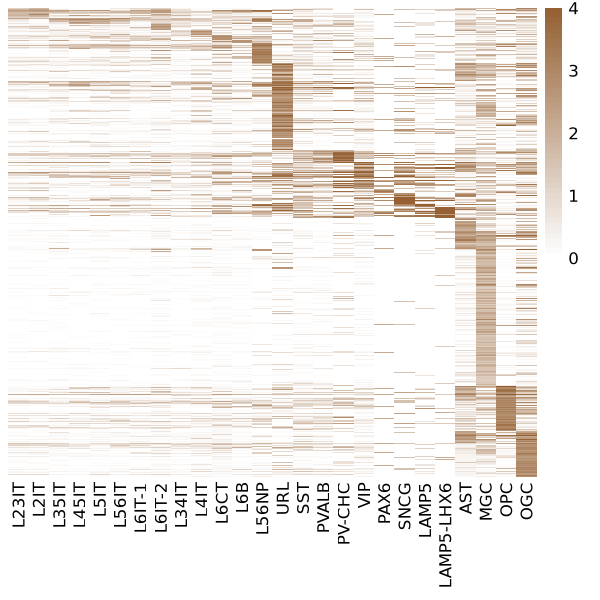

In [89]:
smat <- log2(cpm[intersect(ccre$V5, qpeak), match_name4] + 1)
eorder <- distinct(nmf[, c("V1", "V3")]) %>% 
filter(V1 %in% intersect(ccre$V5, qpeak)) %>%
mutate(V3 = factor(V3, levels = clevel)) %>%
arrange(V3) %>% dplyr::select(V1) %>% unlist %>% as.character # %>% unique

canno1 <- distinct(nmf[, c("V1", "V3")]) %>% dplyr::select(V1, V3) %>% distinct %>%
tibble::column_to_rownames("V1") %>%
mutate(V3 = paste0("M", V3)) %>%
dplyr::select(V3) %>% setNames("Module") %>%
mutate(Module = factor(Module, levels = paste0("M", clevel)))

options(repr.plot.width = 5, repr.plot.height = 5)
fig1 <- smat[eorder, match_name4] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, 
         gap_rows = as.integer(cumsum(table(canno1[eorder,,drop=F]$Module))),
         annotation_row = canno1, annotation_colors = rannocolor,
         border_color = NA, show_rownames = F, breaks = seq(0, 4, 0.08), 
         color = colorRampPalette(c("white", "#956134"))(50))

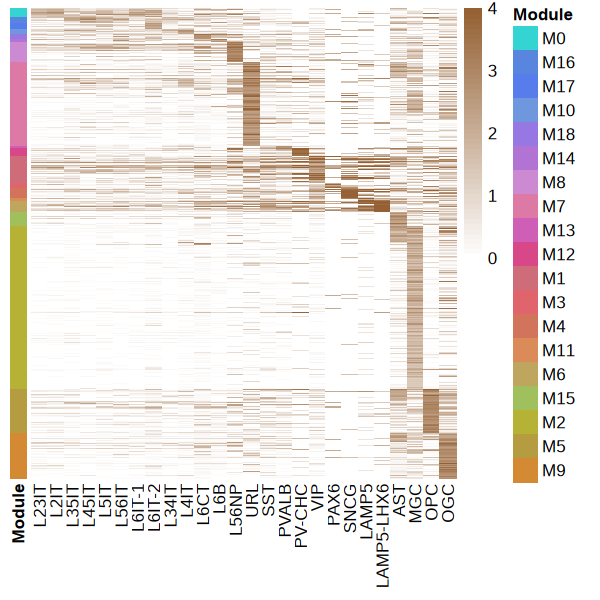

In [467]:
### Plot only ct specific
qqpeak <- ctspeak %>% filter(count == 1) %>% select(peak_id) %>% unlist %>% as.character %>% unique
eorder <- distinct(nmf[, c("V1", "V3")]) %>% 
filter(V1 %in% intersect(ccre$V5, qqpeak)) %>%
mutate(V3 = factor(V3, levels = clevel)) %>%
arrange(V3) %>% dplyr::select(V1) %>% unlist %>% as.character # %>% unique

options(repr.plot.width = 5, repr.plot.height = 5)
fig2 <- smat[eorder, match_name4] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, 
         gap_rows = as.integer(cumsum(table(canno1[eorder,,drop=F]$Module))),
         annotation_row = canno1, annotation_colors = rannocolor,
         border_color = NA, show_rownames = F, breaks = seq(0, 4, 0.08), 
         color = colorRampPalette(c("white", "#956134"))(50))

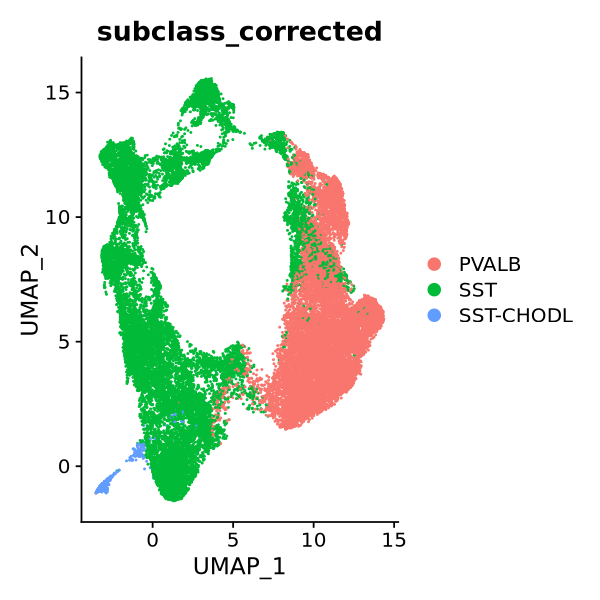

In [17]:
library(anndata)
k27me3 <- read_h5ad("MiniAtlas_H3K27me3_snATAC_whole.union.peaks_250601.h5ad")
qry <- qs::qread("../12.heterogenity/seurat_objects/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250529_MGE_interneuron.qs")

qry$dna_bc <- paste0(qry$dna, ":", qry$atac_bc)
obj <- CreateSeuratObject(t(k27me3$X)[, intersect(k27me3$obs_names, qry$dna_bc)], meta.data = k27me3$obs[intersect(k27me3$obs_names, qry$dna_bc), ], assay = "histone")
obj[["histone"]] <- CreateAssayObject(counts = obj[["histone"]]$counts)

qumap <- qry@reductions$umap@cell.embeddings[obj$rna_bc, ]
rownames(qumap) <- colnames(obj)
obj[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(qumap), key = "UMAP_", assay = "histone")

options(repr.plot.width = 5, repr.plot.height = 5)
DimPlot(obj, group.by = "subclass_corrected")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


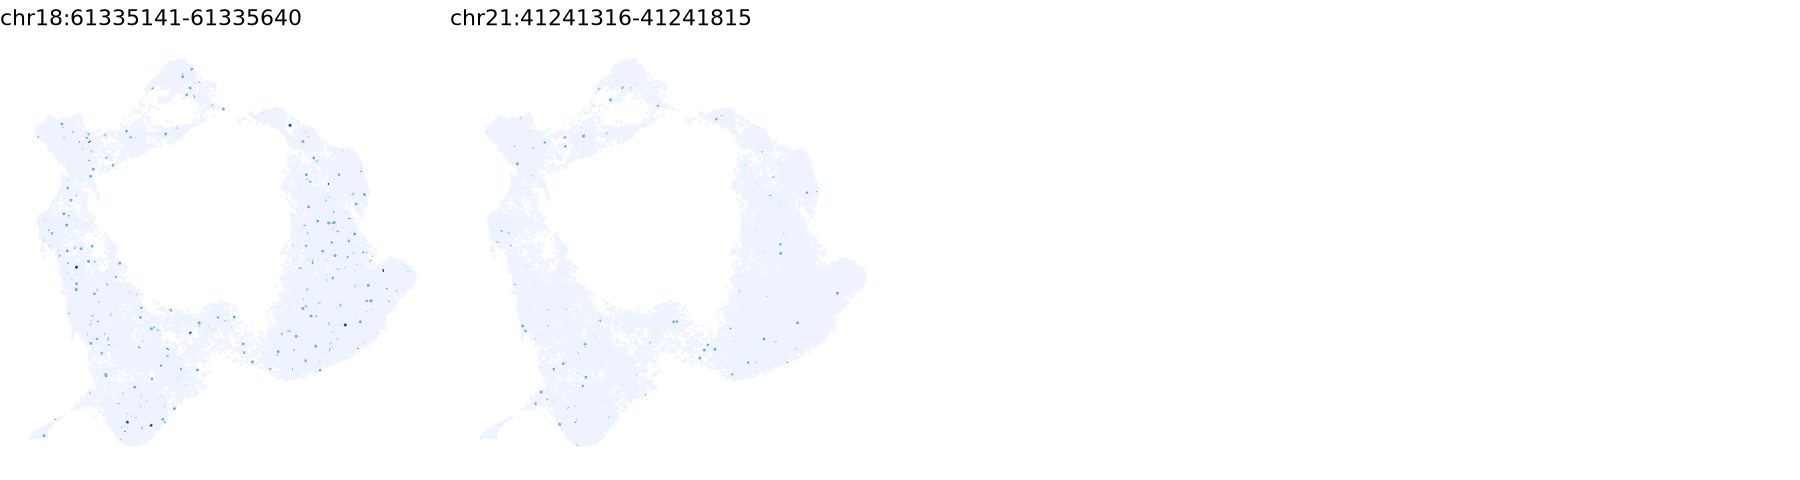

In [24]:
fig1 <- FeaturePlot(obj, features = c("chr18:61335141-61335640", "chr21:41241316-41241815"), 
            reduction = "umap", label = F, repel = T, ncol = 4) & scale_color_distiller(direction = 1) & theme_void() & NoLegend()
options(repr.plot.width = 15, repr.plot.height = 4)
fig1

In [18]:
head(rownames(obj))

[1] "chr1:9848-10347"    "chr1:180570-181069" "chr1:191227-191726"
[4] "chr1:267759-268258" "chr1:585948-586447" "chr1:629697-630196"

## Identify celltype-depleted H3K27me3+ cCREs

In [487]:
### dont do nolinear conversion (e.g. convert cpm to 1/(cpm+1))
jsdc <- read.csv("JSS//K27me3_hba_ccre_LR_neg_JSS_FDR.csv")

idx <- which(jsdc$q_empirical < 0.1)
qpeak2 <- jsdc[idx, ] %>% select(peak_id) %>% unlist %>% as.character %>% unique
length(qpeak2)
intersect(ccre$V5, qpeak2) %>% length
intersect(qpeak, qpeak2) %>% length ### sanity check

[1] 1562

[1] 1562

[1] 1

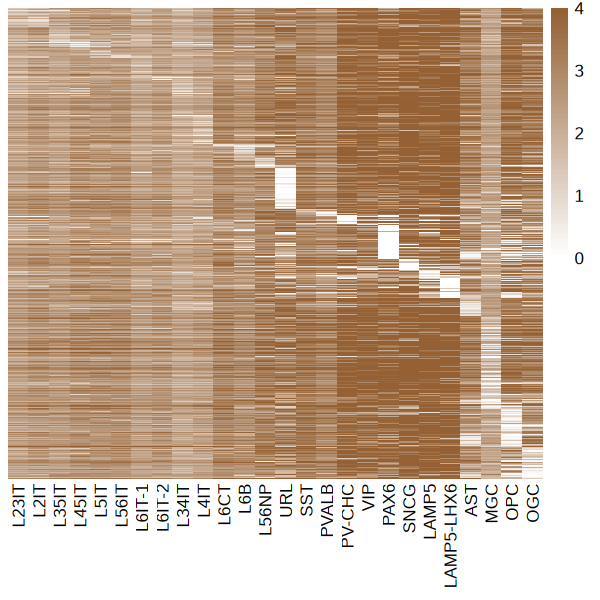

In [488]:
smat <- log2(cpm[intersect(ccre$V5, qpeak2), match_name4] + 1)
max_indices <- max.col(-smat)
permutation_vector <- order(max_indices)

options(repr.plot.width = 5, repr.plot.height = 5)
fig3 <- smat[permutation_vector, ] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, 
         border_color = NA, show_rownames = F, breaks = seq(0, 4, 0.08), 
         color = colorRampPalette(c("white", "#956134"))(50))

In [489]:
ctspeak <- jsdc[idx,] %>%
group_by(peak_id) %>% 
summarise(celltype = paste0(target_group, collapse = '|'), count = n_distinct(target_group)) %>% 
ungroup 

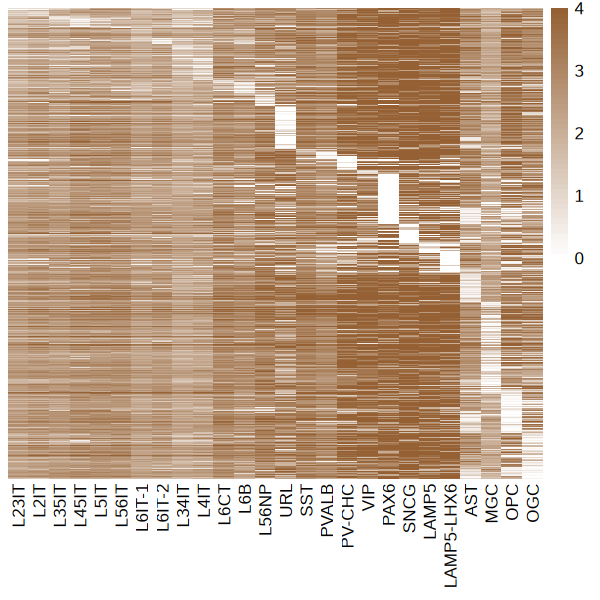

In [490]:
### Plot only specific
qqpeak <- ctspeak %>% filter(count == 1) %>% select(peak_id) %>% unlist %>% as.character %>% unique
smat <- log2(cpm[intersect(ccre$V5, qqpeak), match_name4] + 1)
max_indices <- max.col(-smat)
permutation_vector <- order(max_indices)

options(repr.plot.width = 5, repr.plot.height = 5)
fig4 <- smat[permutation_vector, ] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, 
         border_color = NA, show_rownames = F, breaks = seq(0, 4, 0.08), 
         color = colorRampPalette(c("white", "#956134"))(50))

## Identify epi-variable cCREs

In [28]:
### intersect between H3K27ac+ and H3K27me3+
varelement <- intersect(sig$range, eorder)
varelement %>% length ### variable elements
intersect(nonsig$range, eorder) %>% length

[1] 74090

[1] 57470

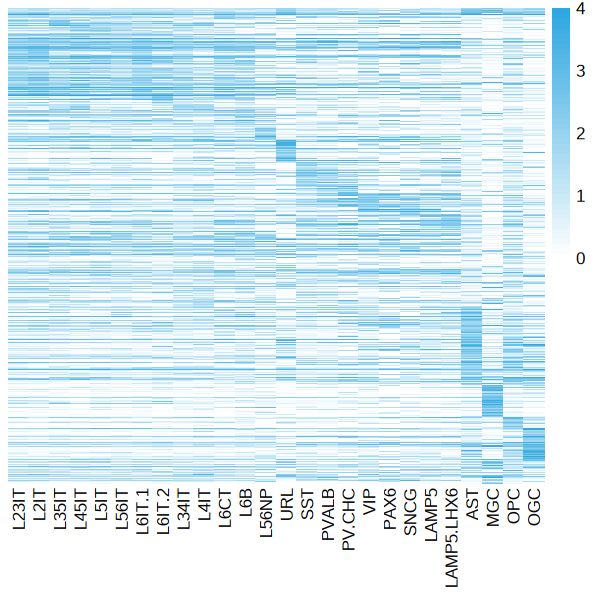

In [29]:
qmtx <- read.table("../Figure/FIG2_H3K27ac_stratify_by_chromhmm_cts_nmf.txt", sep = "\t", row.names = 1, header = T)
t1 <- qmtx[intersect(rownames(qmtx), varelement),] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, 
         border_color = NA, show_rownames = F, breaks = seq(0, 4, 0.08), 
         color = colorRampPalette(c("white", "#2EA7E0"))(50))

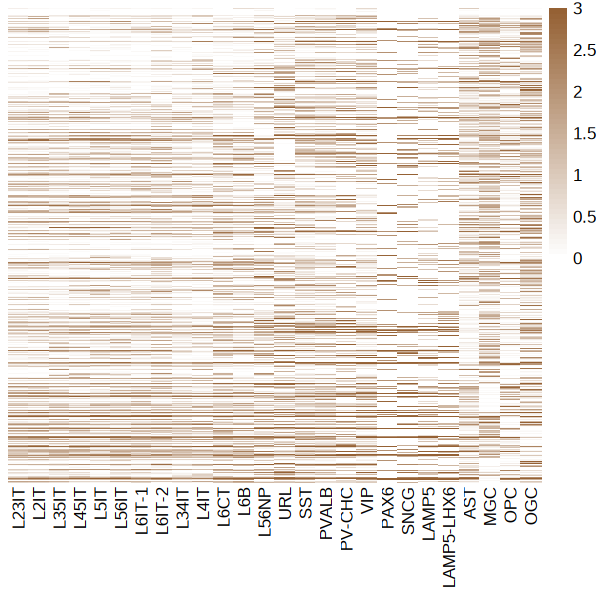

In [30]:
t2 <- smat[intersect(rownames(qmtx), varelement), match_name4] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, 
         border_color = NA, show_rownames = F, breaks = seq(0, 3, 0.06), 
         color = colorRampPalette(c("white", "#956134"))(50))

### Are epi-variable elements are more enhancer-like?

In [311]:
tmp <- sig %>% filter(range %in% varelement)
varrange <- GRanges(tmp[,1], ranges = IRanges(as.numeric(tmp[,2]), as.numeric(tmp[,3])))

### remove proximal?
idx <- queryHits(findOverlaps(wacrange, prange)) %>% unique
idy <- queryHits(findOverlaps(nacrange, prange)) %>% unique
idz <- queryHits(findOverlaps(varrange, prange)) %>% unique

dwacrange <- GRanges(sig[-idx,1], ranges = IRanges(as.numeric(sig[-idx,2]), as.numeric(sig[-idx,3])))
dnacrange <- GRanges(nonsig[-idy,1], ranges = IRanges(as.numeric(nonsig[-idy,2]), as.numeric(nonsig[-idy,3])))
dvarrange <- GRanges(tmp[-idz,1], ranges = IRanges(as.numeric(tmp[-idz,2]), as.numeric(tmp[-idz,3])))

### contingency table
### compare to random
### generate random bed by shuffle
w0 <- queryHits(findOverlaps(sfrange, gcrange)) %>% unique %>% length
w1 <- queryHits(findOverlaps(dwacrange, gcrange)) %>% unique %>% length
w2 <- queryHits(findOverlaps(dnacrange, gcrange)) %>% unique %>% length
w3 <- queryHits(findOverlaps(dvarrange, gcrange)) %>% unique %>% length
cting <- matrix(data = c(w0,(w1+w2),w1, w2, w3,
                         nrow(sfbed) - w0, length(c(nonsig[-idy,1], sig[-idx,1])) - (w1+w2), 
                         length(sig[-idx,1]) - w1, length(nonsig[-idy,1]) - w2,
                         length(tmp[-idz,1]) - w3), 
                nrow = 5, ncol = 2)
cdf <- list()
for (i in c(2:5)){
    cdf[[i]] <- data.frame(pvalue = fisher.test(cting[c(i,1),])$p.value, or = fisher.test(cting[c(i,1),])$estimate) 
}
cdf <- do.call(rbind, cdf)
cdf$group <- c("all cCREs", "with ac", "no ac", "var")

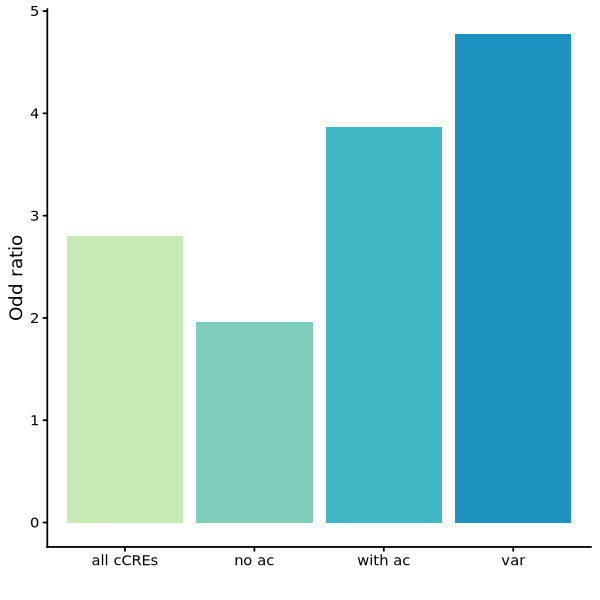

In [316]:
options(repr.plot.width = 5, repr.plot.height = 5)
t1 <- cdf %>%
mutate(group = factor(group, levels = c("all cCREs", "no ac", "with ac", "var"))) %>%
ggplot(aes(x = group, y = or, fill = group)) + 
geom_col() + ylab("Odd ratio") + xlab("") + 
theme_classic() + 
scale_fill_manual(values = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(8)[3:6]) +
NoLegend()     
t1